In [1]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 
from pylab import rcParams 
from statsmodels.graphics.tsaplots import month_plot,plot_acf, plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose,STL 
from   statsmodels.tsa.api             import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error 
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.arima_model import ARIMA 
import statsmodels.api as sm

In [2]:
df=pd.read_csv('Sparkling.csv',parse_dates=['YearMonth'],index_col = 'YearMonth')

In [3]:
df

Sparkling
YearMonth            
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471
...               ...
1995-03-01       1897
1995-04-01       1862
1995-05-01       1670
1995-06-01       1688
1995-07-01       2031

[187 rows x 1 columns]

In [4]:
df2 = pd.read_csv('Rose.csv',parse_dates=['YearMonth'],index_col = 'YearMonth')

In [5]:
df2

Rose
YearMonth        
1980-01-01  112.0
1980-02-01  118.0
1980-03-01  129.0
1980-04-01   99.0
1980-05-01  116.0
...           ...
1995-03-01   45.0
1995-04-01   52.0
1995-05-01   28.0
1995-06-01   40.0
1995-07-01   62.0

[187 rows x 1 columns]

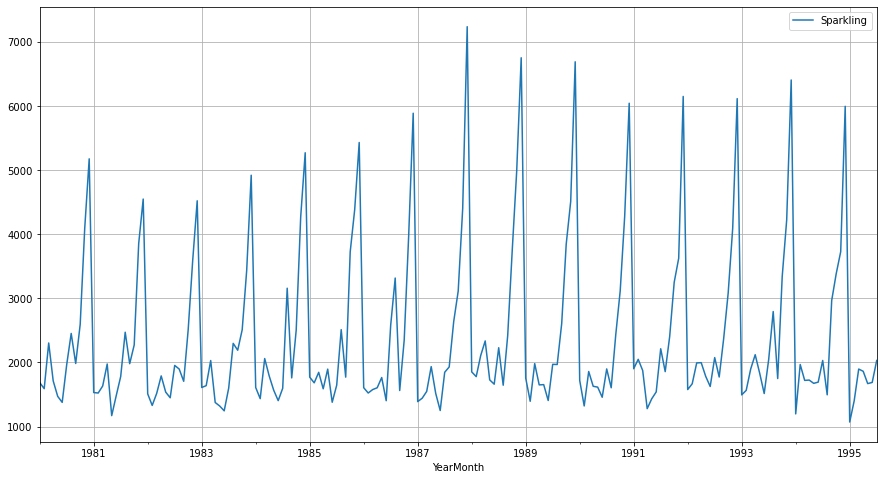

In [43]:
rcParams['figure.figsize']=15,8
df.plot(grid=True);

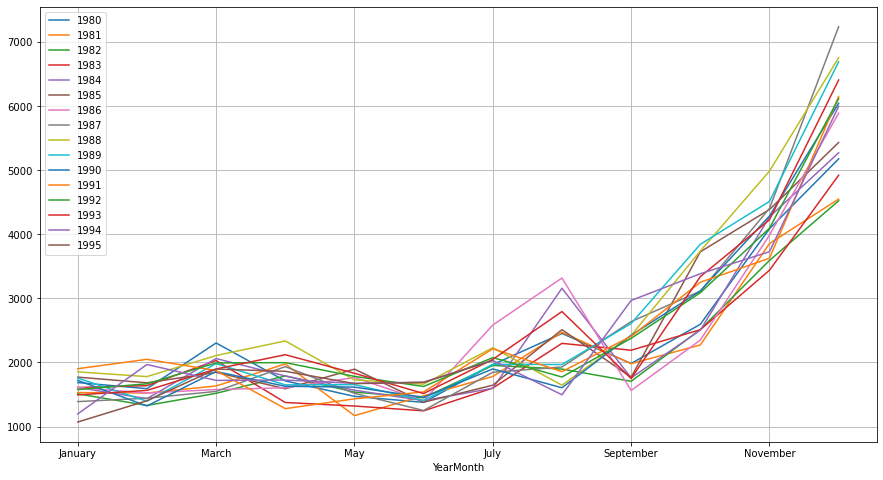

In [44]:
months=['January','February','March','April','May','June','July', 'August','September','October','November','December']
yearly_sales_across_years=pd.pivot_table(df,values='Sparkling',columns=df.index.year,index=df.index.month_name())
yearly_sales_across_years=yearly_sales_across_years.reindex(index=months)
yearly_sales_across_years.plot()
plt.grid()
plt.legend(loc='best');


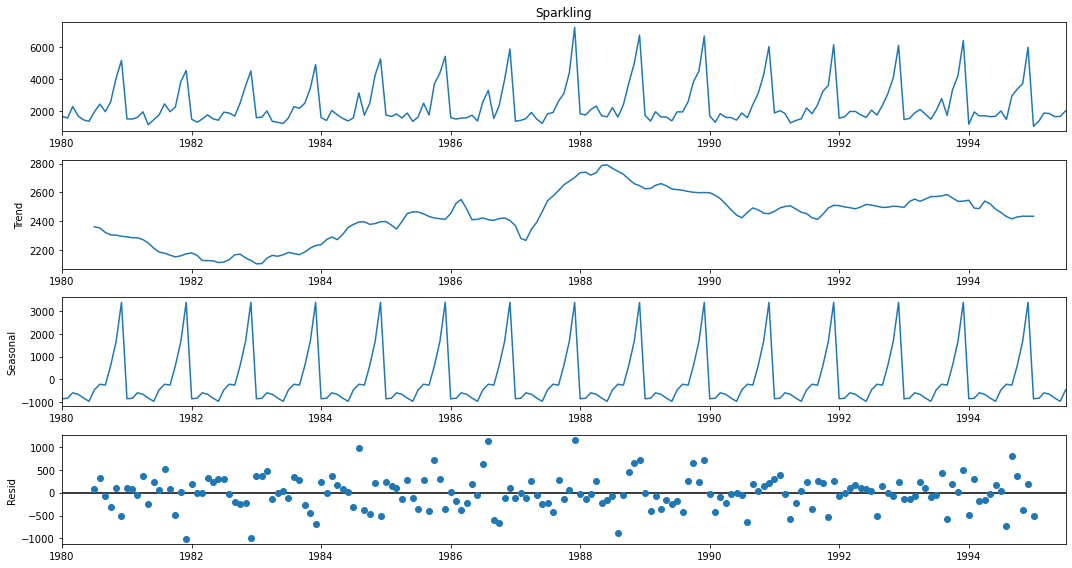

In [49]:
decomposition_df=seasonal_decompose(df['Sparkling'],model='additive')
decomposition_df.plot();

In [52]:
df_Train =df[df.index.year <=1990]
df_Test =df[df.index.year >1990]

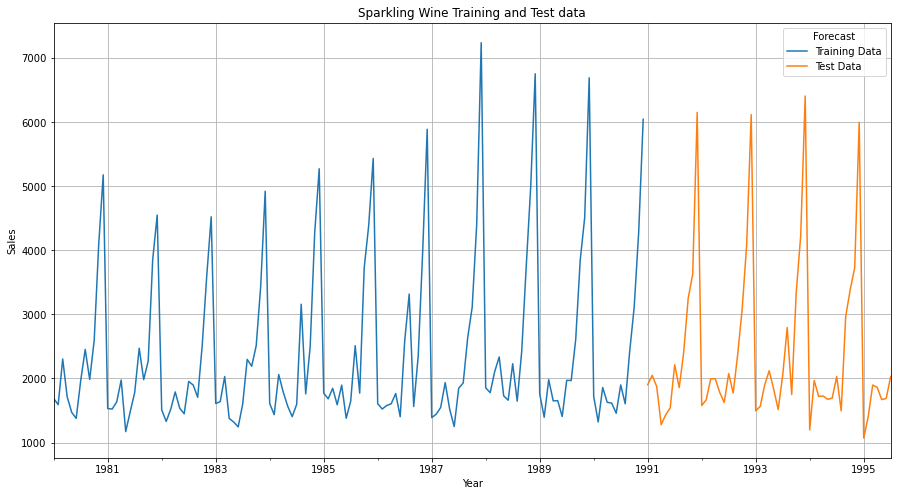

In [53]:
df_Train['Sparkling'].plot()
df_Test['Sparkling'].plot()
plt.grid()
plt.title('Sparkling Wine Training and Test data')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend(['Training Data','Test Data'],title='Forecast');


In [57]:
#SES - ETS(A, N, N) - Simple Exponential Smoothing with additive errors
model_SES = SimpleExpSmoothing(df_Train,initialization_method='estimated')

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [58]:
model_SES_autofit = model_SES.fit(optimized=True)

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [59]:
model_SES_autofit.params

{'smoothing_level': 0.07029120765764557,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1764.0137060346985,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [61]:
SES_predict = model_SES_autofit.forecast(steps=len(df_Test))
SES_predict

1991-01-01    2804.675124
1991-02-01    2804.675124
1991-03-01    2804.675124
1991-04-01    2804.675124
1991-05-01    2804.675124
1991-06-01    2804.675124
1991-07-01    2804.675124
1991-08-01    2804.675124
1991-09-01    2804.675124
1991-10-01    2804.675124
1991-11-01    2804.675124
1991-12-01    2804.675124
1992-01-01    2804.675124
1992-02-01    2804.675124
1992-03-01    2804.675124
1992-04-01    2804.675124
1992-05-01    2804.675124
1992-06-01    2804.675124
1992-07-01    2804.675124
1992-08-01    2804.675124
1992-09-01    2804.675124
1992-10-01    2804.675124
1992-11-01    2804.675124
1992-12-01    2804.675124
1993-01-01    2804.675124
1993-02-01    2804.675124
1993-03-01    2804.675124
1993-04-01    2804.675124
1993-05-01    2804.675124
1993-06-01    2804.675124
1993-07-01    2804.675124
1993-08-01    2804.675124
1993-09-01    2804.675124
1993-10-01    2804.675124
1993-11-01    2804.675124
1993-12-01    2804.675124
1994-01-01    2804.675124
1994-02-01    2804.675124
1994-03-01  

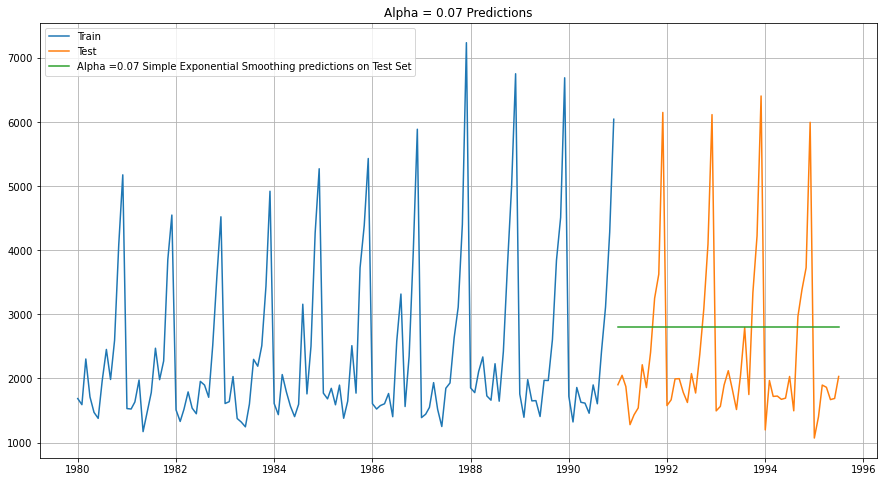

In [73]:
plt.plot(df_Train, label='Train')
plt.plot(df_Test, label='Test')

plt.plot(SES_predict, label='Alpha =0.07 Simple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Alpha = 0.07 Predictions');

In [63]:
def MAPE(y_true, y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100

In [66]:
print('SES RMSE:',mean_squared_error(df_Test.values,SES_predict.values,squared=False))
#different way to calculate RMSE
import statsmodels.tools.eval_measures as      em
print('SES RMSE (calculated using statsmodels):',em.rmse(df_Test.values,SES_predict.values)[0])

SES RMSE: 1338.0083844916467
SES RMSE (calculated using statsmodels): 1338.0083844916464


In [77]:
resultsDf = pd.DataFrame({'Test RMSE': [em.rmse(df_Test.values,SES_predict.values)[0]]},index=['Alpha=0.07,SES'])
resultsDf

Test RMSE
Alpha=0.07,SES  1338.008384

In [69]:
# Holt - ETS(A, A, N) - Holt's linear method with additive errors

In [70]:
model_DES = Holt(df_Train,initialization_method='estimated')
# Fitting the model
model_DES = model_DES.fit()

print('')
print('==Holt model Exponential Smoothing Estimated Parameters ==')
print('')
print(model_DES.params)


==Holt model Exponential Smoothing Estimated Parameters ==

{'smoothing_level': 0.6649999999999999, 'smoothing_trend': 0.0001, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 1502.1999999999991, 'initial_trend': 74.87272727272739, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [71]:
DES_predict =  model_DES.forecast(len(df_Test))
DES_predict

1991-01-01    5401.733026
1991-02-01    5476.005230
1991-03-01    5550.277433
1991-04-01    5624.549637
1991-05-01    5698.821840
1991-06-01    5773.094044
1991-07-01    5847.366248
1991-08-01    5921.638451
1991-09-01    5995.910655
1991-10-01    6070.182858
1991-11-01    6144.455062
1991-12-01    6218.727266
1992-01-01    6292.999469
1992-02-01    6367.271673
1992-03-01    6441.543876
1992-04-01    6515.816080
1992-05-01    6590.088284
1992-06-01    6664.360487
1992-07-01    6738.632691
1992-08-01    6812.904894
1992-09-01    6887.177098
1992-10-01    6961.449302
1992-11-01    7035.721505
1992-12-01    7109.993709
1993-01-01    7184.265912
1993-02-01    7258.538116
1993-03-01    7332.810320
1993-04-01    7407.082523
1993-05-01    7481.354727
1993-06-01    7555.626930
1993-07-01    7629.899134
1993-08-01    7704.171338
1993-09-01    7778.443541
1993-10-01    7852.715745
1993-11-01    7926.987948
1993-12-01    8001.260152
1994-01-01    8075.532356
1994-02-01    8149.804559
1994-03-01  

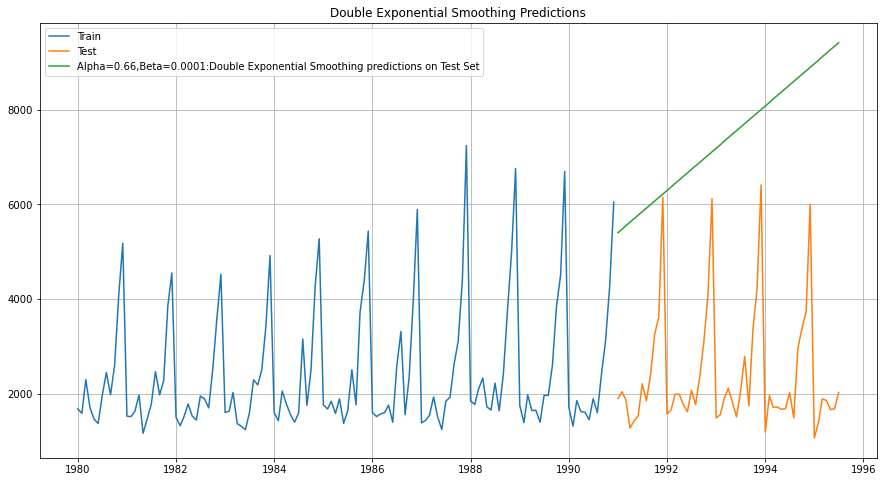

In [91]:
plt.plot(df_Train, label='Train')
plt.plot(df_Test, label='Test')

#plt.plot(SES_predict, label='Alpha=0.07:Simple Exponential Smoothing predictions on Test Set')
plt.plot(DES_predict, label='Alpha=0.66,Beta=0.0001:Double Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Double Exponential Smoothing Predictions');

In [76]:
print('DES RMSE:',mean_squared_error(df_Test.values,DES_predict.values,squared=False))

DES RMSE: 5291.8798332269125


In [79]:
resultsDf_temp = pd.DataFrame({'Test RMSE': [mean_squared_error(df_Test.values,DES_predict.values,squared=False)]}
                           ,index=['Alpha=.66,Beta=0.0001:DES'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])


Test RMSE
Alpha=0.07,SES             1338.008384
Alpha=.66,Beta=0.001:DES   5291.879833
Alpha=.66,Beta=0.0001:DES  5291.879833

In [84]:
resultsDf

Test RMSE
Alpha=0.07,SES             1338.008384
Alpha=.66,Beta=0.0001:DES  5291.879833

In [ ]:
#Holt-Winters - ETS(A, A, A) - Holt Winter's linear method with additive errors

In [85]:
model_TES = ExponentialSmoothing(df_Train,trend='additive',seasonal='additive',initialization_method='estimated')
# Fitting the model
model_TES = model_TES.fit()

print('')
print('==Holt Winters model Exponential Smoothing Estimated Parameters ==')
print('')
print(model_TES.params)

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'



==Holt Winters model Exponential Smoothing Estimated Parameters ==

{'smoothing_level': 0.11127217746964548, 'smoothing_trend': 0.012360783178126748, 'smoothing_seasonal': 0.46071776538894016, 'damping_trend': nan, 'initial_level': 2356.578364436942, 'initial_trend': -0.018474239476475418, 'initial_seasons': array([-636.23349217, -722.98352055, -398.6435547 , -473.43067518,
       -808.42508553, -815.35030575, -384.23066985,   72.99524975,
       -237.44267238,  272.32595851, 1541.37820976, 2590.07753817]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [86]:
TES_predict =  model_TES.forecast(len(df_Test))
TES_predict

1991-01-01    1490.574551
1991-02-01    1204.714462
1991-03-01    1688.941256
1991-04-01    1551.450972
1991-05-01    1461.440602
1991-06-01    1278.907350
1991-07-01    1805.164222
1991-08-01    1679.251604
1991-09-01    2315.687875
1991-10-01    3225.309145
1991-11-01    4299.652613
1991-12-01    6411.161656
1992-01-01    1483.296915
1992-02-01    1197.436826
1992-03-01    1681.663620
1992-04-01    1544.173336
1992-05-01    1454.162966
1992-06-01    1271.629714
1992-07-01    1797.886586
1992-08-01    1671.973968
1992-09-01    2308.410239
1992-10-01    3218.031509
1992-11-01    4292.374977
1992-12-01    6403.884020
1993-01-01    1476.019279
1993-02-01    1190.159190
1993-03-01    1674.385984
1993-04-01    1536.895700
1993-05-01    1446.885330
1993-06-01    1264.352078
1993-07-01    1790.608950
1993-08-01    1664.696332
1993-09-01    2301.132603
1993-10-01    3210.753873
1993-11-01    4285.097341
1993-12-01    6396.606384
1994-01-01    1468.741643
1994-02-01    1182.881554
1994-03-01  

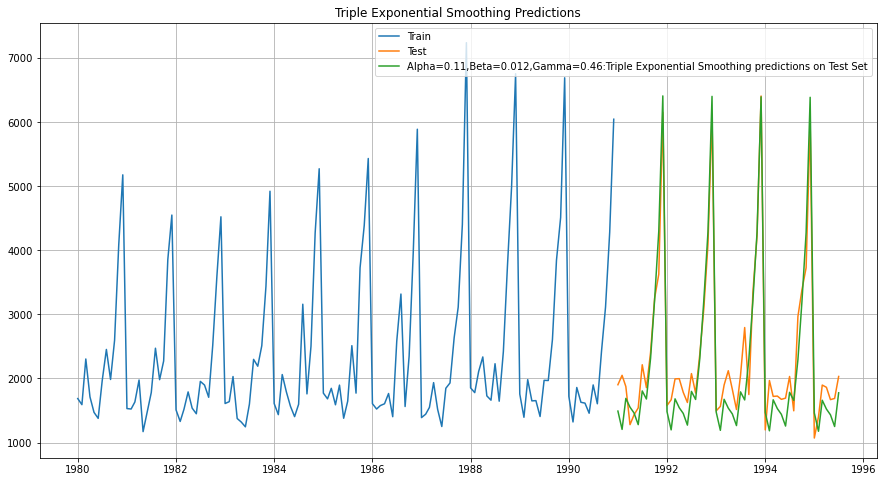

In [92]:
plt.plot(df_Train, label='Train')
plt.plot(df_Test, label='Test')

plt.plot(TES_predict, label='Alpha=0.11,Beta=0.012,Gamma=0.46:Triple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Triple Exponential Smoothing Predictions');

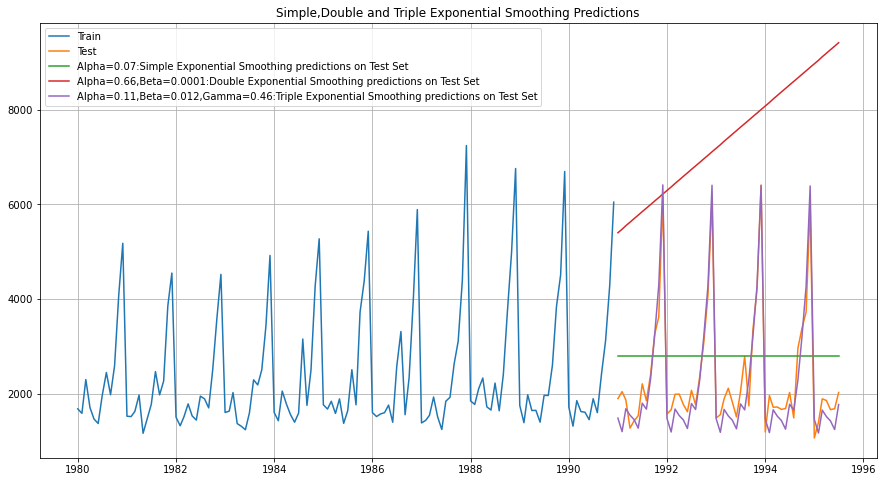

In [87]:
plt.plot(df_Train, label='Train')
plt.plot(df_Test, label='Test')

plt.plot(SES_predict, label='Alpha=0.07:Simple Exponential Smoothing predictions on Test Set')
plt.plot(DES_predict, label='Alpha=0.66,Beta=0.0001:Double Exponential Smoothing predictions on Test Set')
plt.plot(TES_predict, label='Alpha=0.11,Beta=0.012,Gamma=0.46:Triple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Simple,Double and Triple Exponential Smoothing Predictions');

In [89]:
print('TES RMSE:',mean_squared_error(df_Test.values,TES_predict.values,squared=False))

TES RMSE: 378.6260083329619


In [90]:
resultsDf_temp = pd.DataFrame({'Test RMSE': [mean_squared_error(df_Test.values,TES_predict.values,squared=False)]}
                           ,index=['Alpha=0.11,Beta=0.012,Gamma=0.46:TES'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

Test RMSE
Alpha=0.07,SES                        1338.008384
Alpha=.66,Beta=0.0001:DES             5291.879833
Alpha=0.11,Beta=0.012,Gamma=0.46:TES   378.626008

In [ ]:
#Holt-Winters - ETS(A, A, M) - Holt Winter's linear method

In [93]:
model_TES_am = ExponentialSmoothing(df_Train,trend='add',seasonal='multiplicative',initialization_method='estimated')
# Fitting the model
model_TES_am = model_TES_am.fit()

print('')
print('==Holt Winters model Exponential Smoothing Estimated Parameters ==')
print('')
print(model_TES_am.params)

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'



==Holt Winters model Exponential Smoothing Estimated Parameters ==

{'smoothing_level': 0.11101523064586813, 'smoothing_trend': 0.0493150519338607, 'smoothing_seasonal': 0.3624464792152574, 'damping_trend': nan, 'initial_level': 2356.4981157471807, 'initial_trend': -9.804740061967985, 'initial_seasons': array([0.71351261, 0.68262962, 0.90447098, 0.80523467, 0.65565848,
       0.65382021, 0.88609683, 1.13334681, 0.91877227, 1.21174825,
       1.87063097, 2.37421776]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [94]:
TES_predict_am =  model_TES_am.forecast(len(df_Test))
TES_predict_am

1991-01-01    1587.921914
1991-02-01    1356.650344
1991-03-01    1763.350219
1991-04-01    1656.523868
1991-05-01    1542.386219
1991-06-01    1355.480857
1991-07-01    1854.708560
1991-08-01    1820.665822
1991-09-01    2277.675614
1991-10-01    3123.118775
1991-11-01    4130.016056
1991-12-01    5893.139956
1992-01-01    1539.025473
1992-02-01    1314.767912
1992-03-01    1708.771760
1992-04-01    1605.119264
1992-05-01    1494.399399
1992-06-01    1313.199426
1992-07-01    1796.703973
1992-08-01    1763.577111
1992-09-01    2206.069820
1992-10-01    3024.675950
1992-11-01    3999.492295
1992-12-01    5706.403171
1993-01-01    1490.129033
1993-02-01    1272.885480
1993-03-01    1654.193301
1993-04-01    1553.714661
1993-05-01    1446.412578
1993-06-01    1270.917996
1993-07-01    1738.699385
1993-08-01    1706.488400
1993-09-01    2134.464026
1993-10-01    2926.233125
1993-11-01    3868.968534
1993-12-01    5519.666385
1994-01-01    1441.232592
1994-02-01    1231.003048
1994-03-01  

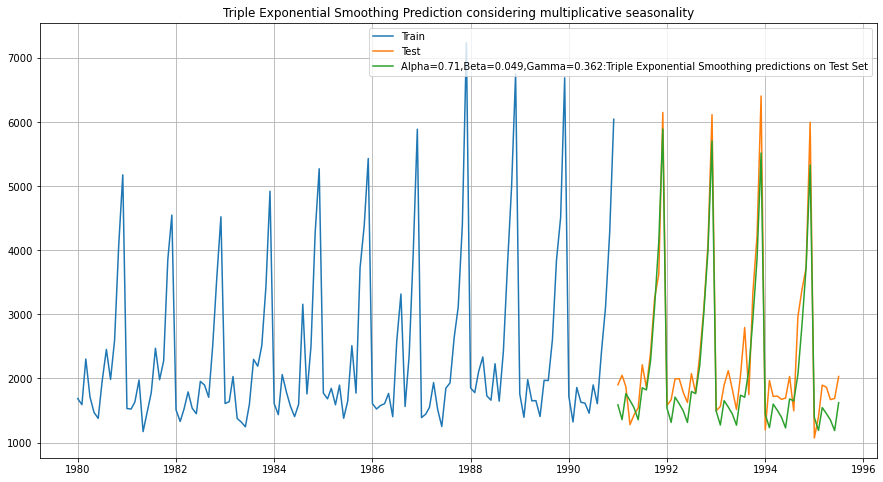

In [99]:
plt.plot(df_Train, label='Train')
plt.plot(df_Test, label='Test')

plt.plot(TES_predict_am, label='Alpha=0.71,Beta=0.049,Gamma=0.362:Triple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Triple Exponential Smoothing Prediction considering multiplicative seasonality');

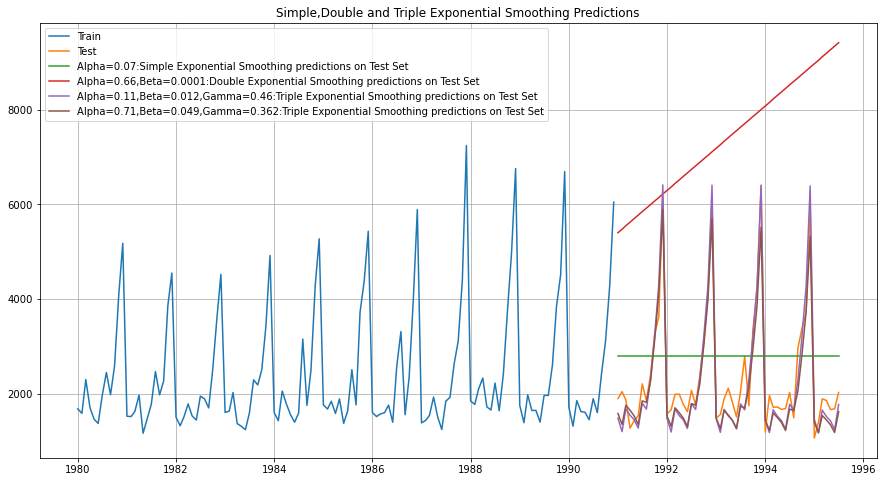

In [95]:
plt.plot(df_Train, label='Train')
plt.plot(df_Test, label='Test')

plt.plot(SES_predict, label='Alpha=0.07:Simple Exponential Smoothing predictions on Test Set')
plt.plot(DES_predict, label='Alpha=0.66,Beta=0.0001:Double Exponential Smoothing predictions on Test Set')
plt.plot(TES_predict, label='Alpha=0.11,Beta=0.012,Gamma=0.46:Triple Exponential Smoothing predictions on Test Set')
plt.plot(TES_predict_am, label='Alpha=0.71,Beta=0.049,Gamma=0.362:Triple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Simple,Double and Triple Exponential Smoothing Predictions');

In [ ]:
smoothing_level': 0.11101523064586813, 'smoothing_trend': 0.0493150519338607, 'smoothing_seasonal': 0.3624464792152574,

In [96]:
print('TES_am RMSE:',mean_squared_error(df_Test.values,TES_predict_am.values,squared=False))

TES_am RMSE: 402.9385298316925


In [98]:
resultsDf_temp = pd.DataFrame({'Test RMSE': [mean_squared_error(df_Test.values,TES_predict_am.values,squared=False)]}
                           ,index=['Alpha=0.71,Beta=0.049,Gamma=0.362:TES'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

Test RMSE
Alpha=0.07,SES                         1338.008384
Alpha=.66,Beta=0.0001:DES              5291.879833
Alpha=0.11,Beta=0.012,Gamma=0.46:TES    378.626008
Alpha=0.71,Beta=0.049,Gamma=0.362:TES   402.938530

### Building different models and comparing the accuracy metrics.

#### Model 1: Linear Regression

In [100]:
len(df_Train)

132

In [101]:
train_time = [i+1 for i in range(len(df_Train))]
test_time = [i+132 for i in range(len(df_Test))]

In [102]:
LinearRegression_train = df_Train.copy()
LinearRegression_test = df_Test.copy()

In [103]:
LinearRegression_train['time'] = train_time
LinearRegression_test['time'] = test_time

In [104]:
from sklearn.linear_model import LinearRegression

In [105]:
lr = LinearRegression()

In [106]:
lr.fit(LinearRegression_train[['time']],LinearRegression_train['Sparkling'].values)

LinearRegression()

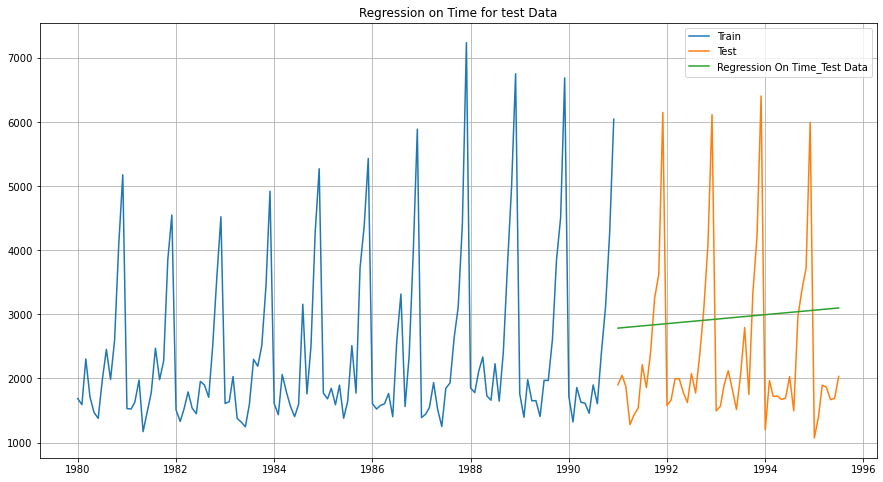

In [267]:
test_predictions_model1 = lr.predict(LinearRegression_test[['time']])
LinearRegression_test['RegOnTime'] = test_predictions_model1


plt.plot( df_Train['Sparkling'], label='Train')
plt.plot(df_Test['Sparkling'], label='Test')
plt.plot(LinearRegression_test['RegOnTime'], label='Regression On Time_Test Data')
plt.legend(loc='best')
plt.title('Regression on Time for test Data')
plt.grid();

In [110]:
from sklearn import metrics
print("For RegressionOnTime forecast on the Test Data,  RMSE is %3.3f" %(metrics.mean_squared_error(df_Test['Sparkling'],test_predictions_model1,squared=False)))

For RegressionOnTime forecast on the Test Data,  RMSE is 1386.836


In [111]:
resultsDf_temp = pd.DataFrame({'Test RMSE': [mean_squared_error(df_Test['Sparkling'],test_predictions_model1,squared=False)]},index=['Linear Regression'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

Test RMSE
Alpha=0.07,SES                         1338.008384
Alpha=.66,Beta=0.0001:DES              5291.879833
Alpha=0.11,Beta=0.012,Gamma=0.46:TES    378.626008
Alpha=0.71,Beta=0.049,Gamma=0.362:TES   402.938530
Linear Regression                      1386.836243

In [119]:
# Model 2: Naive Approach

In [112]:
NaiveModel_train = df_Train.copy()
NaiveModel_test = df_Test.copy()

In [114]:
NaiveModel_test['naive'] = np.asarray(NaiveModel_train['Sparkling'])[len(np.asarray(NaiveModel_train['Sparkling']))-1]
NaiveModel_test['naive'].head()

YearMonth
1991-01-01    6047
1991-02-01    6047
1991-03-01    6047
1991-04-01    6047
1991-05-01    6047
Name: naive, dtype: int64

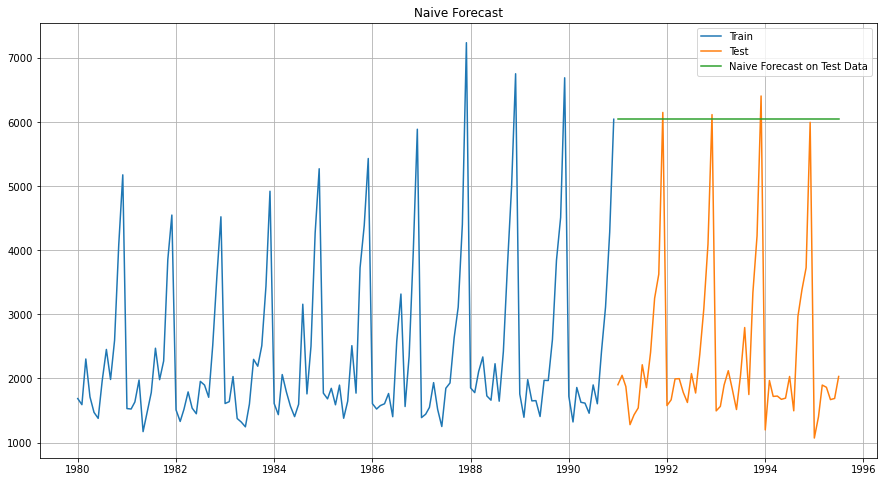

In [125]:

plt.plot(NaiveModel_train['Sparkling'], label='Train')
plt.plot(NaiveModel_test['Sparkling'], label='Test')
plt.plot(NaiveModel_test['naive'], label='Naive Forecast on Test Data')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.grid();

In [268]:
rmse_model2_test = metrics.mean_squared_error(NaiveModel_test['Sparkling'],NaiveModel_test['naive'],squared=False)
print("For Naive Model forecast on the Test Data,  RMSE is %3.3f" %(rmse_model2_test))

For Naive Model forecast on the Test Data,  RMSE is 3864.279


In [118]:
resultsDf_2 = pd.DataFrame({'Test RMSE': [rmse_model2_test]},index=['NaiveModel'])

resultsDf = pd.concat([resultsDf, resultsDf_2])
resultsDf

Test RMSE
Alpha=0.07,SES                         1338.008384
Alpha=.66,Beta=0.0001:DES              5291.879833
Alpha=0.11,Beta=0.012,Gamma=0.46:TES    378.626008
Alpha=0.71,Beta=0.049,Gamma=0.362:TES   402.938530
Linear Regression                      1386.836243
NaiveModel                             3864.279352

In [120]:
# Method 3: Simple Average

In [121]:
SimpleAverage_train = df_Train.copy()
SimpleAverage_test = df_Test.copy()

In [122]:
SimpleAverage_test['mean_forecast'] = SimpleAverage_train['Sparkling'].mean()
SimpleAverage_test.head()

Sparkling  mean_forecast
YearMonth                           
1991-01-01       1902    2403.780303
1991-02-01       2049    2403.780303
1991-03-01       1874    2403.780303
1991-04-01       1279    2403.780303
1991-05-01       1432    2403.780303

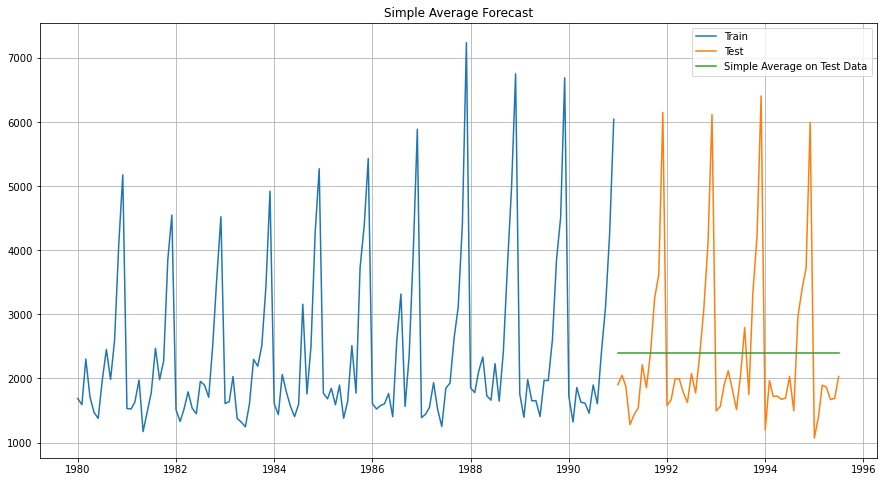

In [126]:

plt.plot(SimpleAverage_train['Sparkling'], label='Train')
plt.plot(SimpleAverage_test['Sparkling'], label='Test')
plt.plot(SimpleAverage_test['mean_forecast'], label='Simple Average on Test Data')
plt.legend(loc='best')
plt.title("Simple Average Forecast")
plt.grid();

In [127]:
rmse_model3_test = metrics.mean_squared_error(SimpleAverage_test['Sparkling'],SimpleAverage_test['mean_forecast'],squared=False)
print("For Simple Average forecast on the Test Data,  RMSE is %3.3f" %(rmse_model3_test))

For Simple Average forecast on the Test Data,  RMSE is 1275.082


In [128]:
resultsDf_3 = pd.DataFrame({'Test RMSE': [rmse_model3_test]},index=['SimpleAverageModel'])

resultsDf = pd.concat([resultsDf, resultsDf_3])
resultsDf

Test RMSE
Alpha=0.07,SES                         1338.008384
Alpha=.66,Beta=0.0001:DES              5291.879833
Alpha=0.11,Beta=0.012,Gamma=0.46:TES    378.626008
Alpha=0.71,Beta=0.049,Gamma=0.362:TES   402.938530
Linear Regression                      1386.836243
NaiveModel                             3864.279352
SimpleAverageModel                     1275.081804

In [129]:
#Method 4: Moving Average(MA)

In [130]:
MovingAverage = df.copy()
MovingAverage.head()

Sparkling
YearMonth            
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471

In [131]:
MovingAverage['Trailing_2'] = MovingAverage['Sparkling'].rolling(2).mean()
MovingAverage['Trailing_4'] = MovingAverage['Sparkling'].rolling(4).mean()
MovingAverage['Trailing_6'] = MovingAverage['Sparkling'].rolling(6).mean()
MovingAverage['Trailing_9'] = MovingAverage['Sparkling'].rolling(9).mean()

MovingAverage.head()

Sparkling  Trailing_2  Trailing_4  Trailing_6  Trailing_9
YearMonth                                                            
1980-01-01       1686         NaN         NaN         NaN         NaN
1980-02-01       1591      1638.5         NaN         NaN         NaN
1980-03-01       2304      1947.5         NaN         NaN         NaN
1980-04-01       1712      2008.0     1823.25         NaN         NaN
1980-05-01       1471      1591.5     1769.50         NaN         NaN

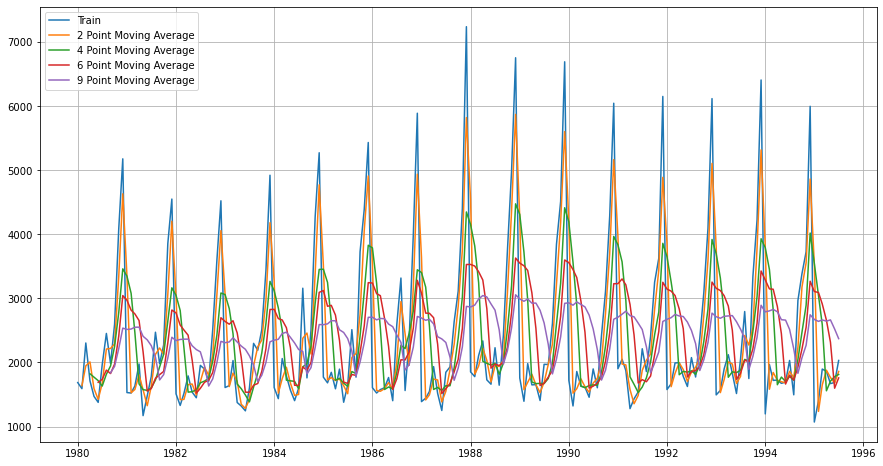

In [132]:
plt.plot(MovingAverage['Sparkling'], label='Train')
plt.plot(MovingAverage['Trailing_2'], label='2 Point Moving Average')
plt.plot(MovingAverage['Trailing_4'], label='4 Point Moving Average')
plt.plot(MovingAverage['Trailing_6'],label = '6 Point Moving Average')
plt.plot(MovingAverage['Trailing_9'],label = '9 Point Moving Average')

plt.legend(loc = 'best')
plt.grid();

In [134]:
trailing_MovingAverage_train=MovingAverage[MovingAverage.index.year<= 1990] 
trailing_MovingAverage_test=MovingAverage[MovingAverage.index.year>1990]

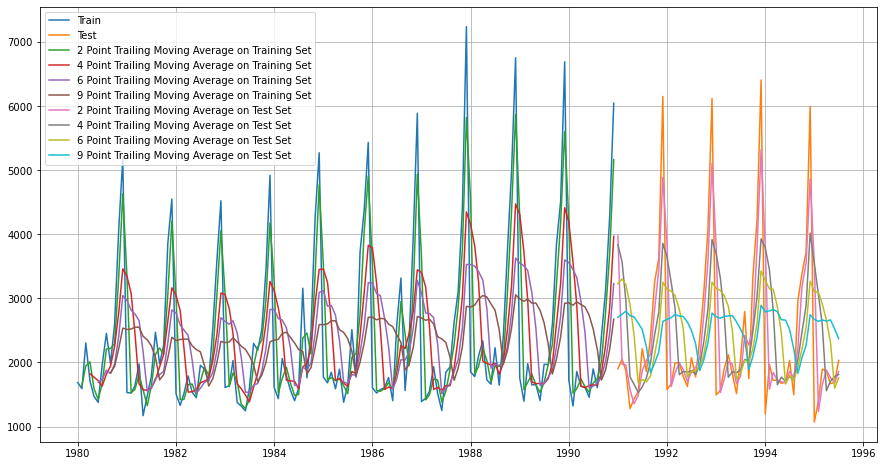

In [135]:
plt.plot(trailing_MovingAverage_train['Sparkling'], label='Train')
plt.plot(trailing_MovingAverage_test['Sparkling'], label='Test')

plt.plot(trailing_MovingAverage_train['Trailing_2'], label='2 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_4'], label='4 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_6'],label = '6 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_9'],label = '9 Point Trailing Moving Average on Training Set')

plt.plot(trailing_MovingAverage_test['Trailing_2'], label='2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_4'], label='4 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_6'],label = '6 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_9'],label = '9 Point Trailing Moving Average on Test Set')
plt.legend(loc = 'best')
plt.grid();

In [136]:
## Test Data - RMSE --> 2 point Trailing MA

rmse_model4_test_2 = metrics.mean_squared_error(trailing_MovingAverage_test['Sparkling'],trailing_MovingAverage_test['Trailing_2'],squared=False)
print("For 2 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_2))

## Test Data - RMSE  --> 4 point Trailing MA

rmse_model4_test_4 = metrics.mean_squared_error(trailing_MovingAverage_test['Sparkling'],trailing_MovingAverage_test['Trailing_4'],squared=False)
print("For 4 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_4))

## Test Data - RMSE --> 6 point Trailing MA

rmse_model4_test_6 = metrics.mean_squared_error(trailing_MovingAverage_test['Sparkling'],trailing_MovingAverage_test['Trailing_6'],squared=False)
print("For 6 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_6))

## Test Data - RMSE  --> 9 point Trailing MA

rmse_model4_test_9 = metrics.mean_squared_error(trailing_MovingAverage_test['Sparkling'],trailing_MovingAverage_test['Trailing_9'],squared=False)
print("For 9 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f " %(rmse_model4_test_9))

For 2 point Moving Average Model forecast on the Training Data,  RMSE is 813.401
For 4 point Moving Average Model forecast on the Training Data,  RMSE is 1156.590
For 6 point Moving Average Model forecast on the Training Data,  RMSE is 1283.927
For 9 point Moving Average Model forecast on the Training Data,  RMSE is 1346.278 


In [137]:
resultsDf_4 = pd.DataFrame({'Test RMSE': [rmse_model4_test_2,rmse_model4_test_4
                                          ,rmse_model4_test_6,rmse_model4_test_9]}
                           ,index=['2pointTrailingMovingAverage','4pointTrailingMovingAverage'
                                   ,'6pointTrailingMovingAverage','9pointTrailingMovingAverage'])

resultsDf = pd.concat([resultsDf, resultsDf_4])
resultsDf

Test RMSE
Alpha=0.07,SES                         1338.008384
Alpha=.66,Beta=0.0001:DES              5291.879833
Alpha=0.11,Beta=0.012,Gamma=0.46:TES    378.626008
Alpha=0.71,Beta=0.049,Gamma=0.362:TES   402.938530
Linear Regression                      1386.836243
NaiveModel                             3864.279352
SimpleAverageModel                     1275.081804
2pointTrailingMovingAverage             813.400684
4pointTrailingMovingAverage            1156.589694
6pointTrailingMovingAverage            1283.927428
9pointTrailingMovingAverage            1346.278315

In [ ]:
# Check for the stationarity of the data
#Augmented  Dickey-Fuller  Test: A  formal  test  to  check  whether  time  series  data  follows stationary process.
#H0: Time series is non-stationary
#H1: Time series is stationary

In [138]:
dftest=adfuller(df_Train,regression='ct',autolag=None,maxlag=24)
print('DF test statistic is %3.3f'%dftest[0])
print('DF test p-value is',dftest[1])
print('Number of lags used',dftest[2])

DF test statistic is -1.586
DF test p-value is 0.7980379297590474
Number of lags used 24


In [139]:
# Sales is not Stationary

In [140]:
df_Train_log=np.log10(df_Train)
dftest=adfuller(df_Train_log,regression='ct',autolag=None,maxlag=24)
print('DF test statistic is %3.3f'%dftest[0])
print('DF test p-value is',dftest[1])
print('Number of lags used',dftest[2])

DF test statistic is -1.871
DF test p-value is 0.669332209553601
Number of lags used 24


In [141]:
#Neither  original  nor  log-transformed  series  is  stationary.  Hence, a  stationarization  is necessary.
#Often differencing a non-stationary time series leadsto a stationary series.

In [142]:
dftest = adfuller(df_Train.diff().dropna(),regression='ct')
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is' ,dftest[1])
print('Number of lags used' ,dftest[2])

DF test statistic is -7.968
DF test p-value is 8.479210655515133e-11
Number of lags used 11


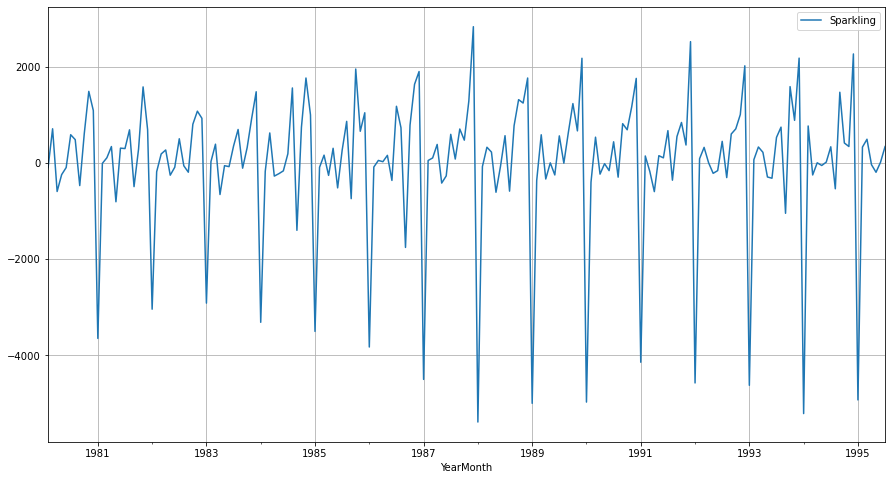

In [143]:
df.diff().dropna().plot(grid=True);

In [144]:
new_df = df.diff().dropna()

In [145]:
new_dftest = adfuller(new_df,regression='ct')
print('DF test statistic is %3.3f' %new_dftest[0])
print('DF test p-value is' ,new_dftest[1])
print('Number of lags used' ,new_dftest[2])

DF test statistic is -44.912
DF test p-value is 0.0
Number of lags used 10


In [146]:
# Plot the Autocorrelation and the Partial Autocorrelation function plots on the whole data.

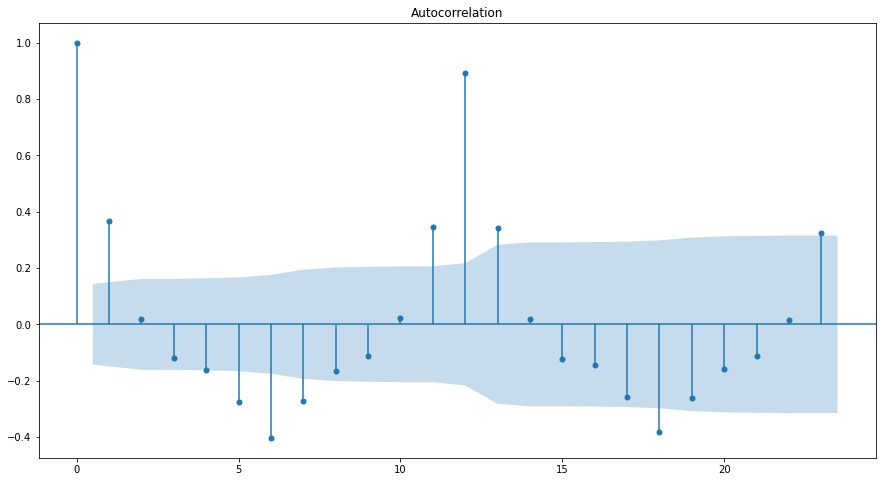

In [147]:
plot_acf(df,alpha=0.05);

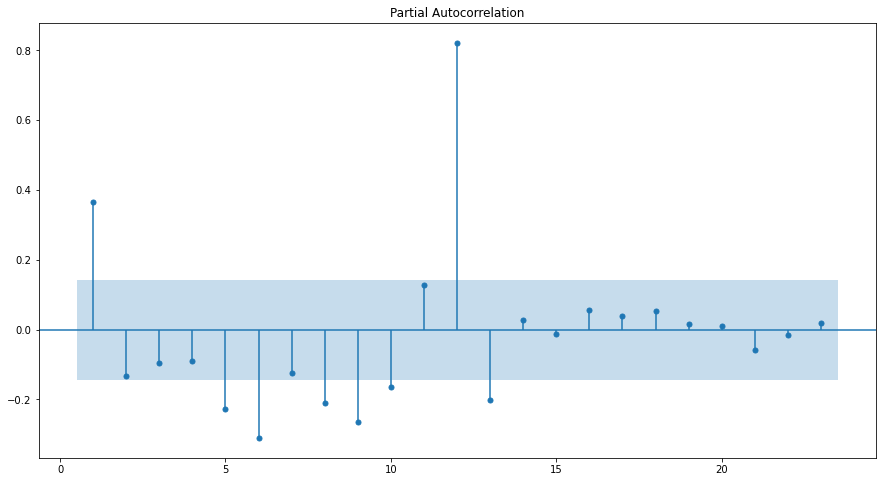

In [148]:
plot_pacf(df,zero=False,alpha=0.05,method='ywmle');

In [149]:
#Build an automated version of the ARIMA/SARIMA model in which the parameters are selected using the lowest Akaike Information Criteria (AIC) on the training data and evaluate this model on the test data using RMSE.

In [152]:
#new_df_Train =new_df[new_df.index.year <=1990]
#new_df_Test =new_df[new_df.index.year >1990]

In [150]:
import itertools
p = q = range(0, 4)
d= range(1,2)
pdq = list(itertools.product(p, d, q))
print('Examples of the parameter combinations for the Model')
for i in range(0,len(pdq)):
    print('Model: {}'.format(pdq[i]))

Examples of the parameter combinations for the Model
Model: (0, 1, 0)
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (0, 1, 3)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (1, 1, 3)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)
Model: (2, 1, 3)
Model: (3, 1, 0)
Model: (3, 1, 1)
Model: (3, 1, 2)
Model: (3, 1, 3)


In [151]:
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC

Empty DataFrame
Columns: [param, AIC]
Index: []

In [154]:
for param in pdq:# running a loop within the pdq parameters defined by itertools
    ARIMA_model = ARIMA(df_Train['Sparkling'].values,order=param).fit()#fitting the ARIMA model
    #using the parameters from the loop
    print('ARIMA{} - AIC:{}'.format(param,ARIMA_model.aic))#printing the parameters and the AIC
    #from the fitted models
    ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
    #appending the AIC values and the model parameters to the previously created data frame
    #for easier understanding and sorting of the AIC values

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA(0, 1, 0) - AIC:2269.582796371201
ARIMA(0, 1, 1) - AIC:2264.906438611577
ARIMA(0, 1, 2) - AIC:2232.78309768405
ARIMA(0, 1, 3) - AIC:2233.016605137543
ARIMA(1, 1, 0) - AIC:2268.5280607650034


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA(1, 1, 1) - AIC:2235.0139453493175


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA(1, 1, 2) - AIC:2233.597647121205


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA(1, 1, 3) - AIC:2234.5741415460398
ARIMA(2, 1, 0) - AIC:2262.035600155025


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA(2, 1, 1) - AIC:2232.3604899121387


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning

ARIMA(2, 1, 2) - AIC:2210.6260491378257


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning

ARIMA(2, 1, 3) - AIC:2229.3580937707247
ARIMA(3, 1, 0) - AIC:2259.471554891012


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA(3, 1, 1) - AIC:2233.9217586494697


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning

ARIMA(3, 1, 2) - AIC:2228.9278973619453
ARIMA(3, 1, 3) - AIC:2225.661558525123


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [155]:
ARIMA_AIC.sort_values(by='AIC',ascending=True).head()

param          AIC
16  (2, 1, 2)  2210.626049
21  (3, 1, 3)  2225.661559
3   (0, 1, 3)  2228.672181
20  (3, 1, 2)  2228.927897
17  (2, 1, 3)  2229.358094

In [162]:
auto_ARIMA = ARIMA(df_Train, order=(2,1,2))

results_auto_ARIMA = auto_ARIMA.fit()

print(results_auto_ARIMA.summary())

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:              Sparkling   No. Observations:                  132
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1101.755
Date:                Wed, 15 Dec 2021   AIC                           2213.509
Time:                        17:41:34   BIC                           2227.885
Sample:                    01-01-1980   HQIC                          2219.351
                         - 12-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3121      0.046     28.781      0.000       1.223       1.401
ar.L2         -0.5593      0.072     -7.741      0.000      -0.701      -0.418
ma.L1         -1.9917      0.109    -18.218      0.0

In [163]:
from statsmodels.tsa.arima.model import ARIMA


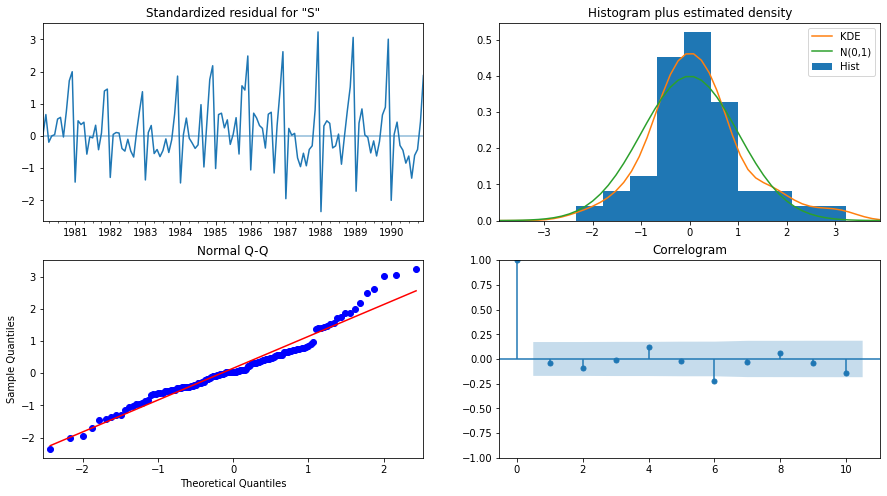

In [165]:
results_auto_ARIMA.plot_diagnostics();

In [166]:
predicted_auto_ARIMA = results_auto_ARIMA.forecast(steps=len(df_Test))

In [168]:
rmse_model5 = mean_squared_error(df_Test['Sparkling'],predicted_auto_ARIMA,squared=False)

print("For Auto ARIMA Model forecast on the Training Data,  RMSE is %3.3f " %(rmse_model5))



For Auto ARIMA Model forecast on the Training Data,  RMSE is 1299.980 


In [169]:
resultsDf_5 = pd.DataFrame({'Test RMSE': [rmse_model5]}
                           ,index=['AutoARIMA(2,1,2)'])

resultsDf = pd.concat([resultsDf, resultsDf_5])
resultsDf

Test RMSE
Alpha=0.07,SES                         1338.008384
Alpha=.66,Beta=0.0001:DES              5291.879833
Alpha=0.11,Beta=0.012,Gamma=0.46:TES    378.626008
Alpha=0.71,Beta=0.049,Gamma=0.362:TES   402.938530
Linear Regression                      1386.836243
NaiveModel                             3864.279352
SimpleAverageModel                     1275.081804
2pointTrailingMovingAverage             813.400684
4pointTrailingMovingAverage            1156.589694
6pointTrailingMovingAverage            1283.927428
9pointTrailingMovingAverage            1346.278315
AutoARIMA(2,1,2)                       1299.979640

In [ ]:
# Build a version of the ARIMA model for which the best parameters are selected by looking at the ACF and the PACF plots.

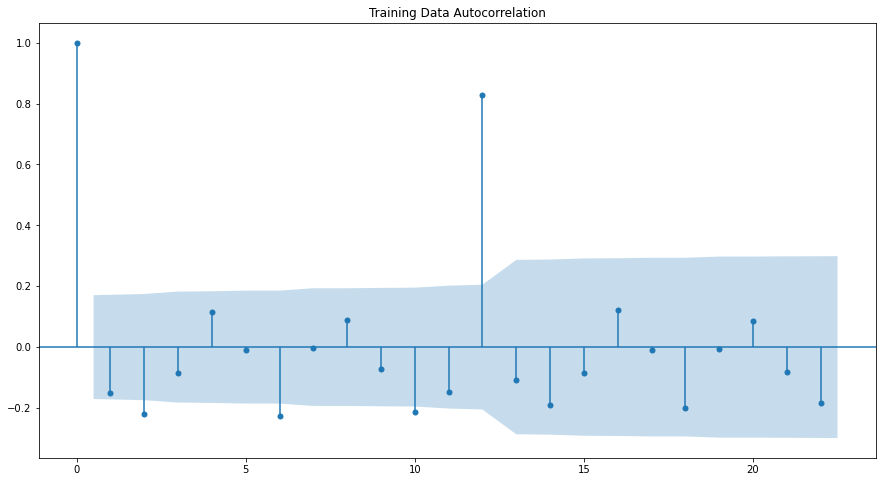

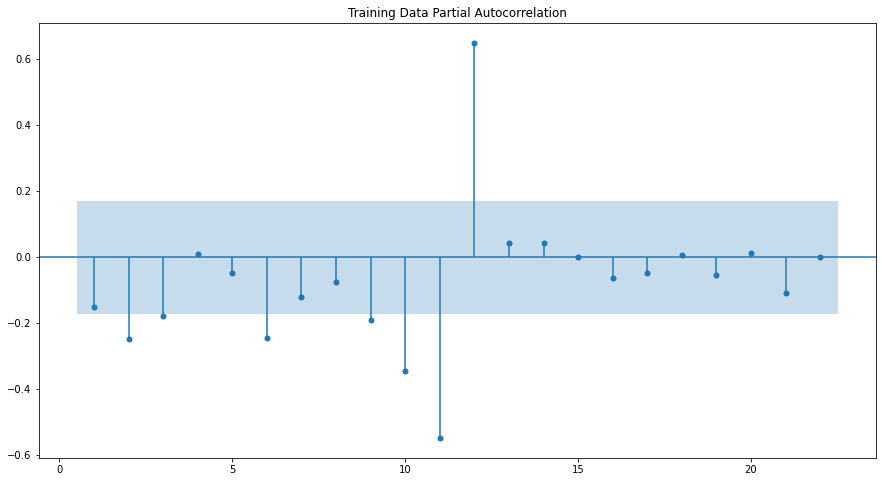

In [170]:
plot_acf(df_Train.diff(),title='Training Data Autocorrelation',missing='drop')
plot_pacf(df_Train.diff().dropna(),title='Training Data Partial Autocorrelation',zero=False,method='ywmle')
plt.show()

Here, we have taken alpha=0.05.

* The Auto-Regressive parameter in an ARIMA model is 'p' which comes from the significant lag before which the PACF plot cuts-off to 2.
* The Moving-Average parameter in an ARIMA model is 'q' which comes from the significant lag before the ACF plot cuts-off to 3.

By looking at the above plots, we will take the value of p and q to be 3 and 2 respectively.

In [180]:
manual_ARIMA = ARIMA(df_Train['Sparkling'], order=(3,1,2))

results_manual_ARIMA = manual_ARIMA.fit()

print(results_manual_ARIMA.summary())

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:              Sparkling   No. Observations:                  132
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1109.476
Date:                Wed, 15 Dec 2021   AIC                           2230.952
Time:                        18:08:22   BIC                           2248.204
Sample:                    01-01-1980   HQIC                          2237.962
                         - 12-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4155      0.043     -9.746      0.000      -0.499      -0.332
ar.L2          0.3242      0.120      2.704      0.007       0.089       0.559
ar.L3         -0.2603      0.077     -3.362      0.0

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


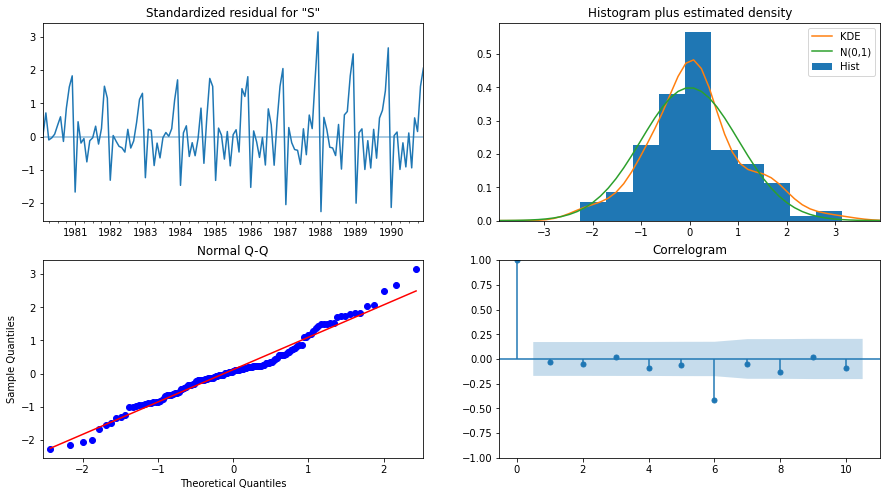

In [181]:
results_manual_ARIMA.plot_diagnostics();

In [182]:
predicted_manual_ARIMA = results_manual_ARIMA.forecast(steps=len(df_Test))

In [183]:
rmse_model6 = mean_squared_error(df_Test['Sparkling'],predicted_manual_ARIMA,squared=False)

print("For Manual ARIMA Model forecast on the Training Data,  RMSE is %3.3f " %(rmse_model6))

For Auto ARIMA Model forecast on the Training Data,  RMSE is 1286.235 


In [187]:
resultsDf_6 = pd.DataFrame({'Test RMSE': [rmse_model6]}
                           ,index=['ManualARIMA(3,1,2)'])

resultsDf = pd.concat([resultsDf, resultsDf_6])
resultsDf

Test RMSE
Alpha=0.07,SES                         1338.008384
Alpha=.66,Beta=0.0001:DES              5291.879833
Alpha=0.11,Beta=0.012,Gamma=0.46:TES    378.626008
Alpha=0.71,Beta=0.049,Gamma=0.362:TES   402.938530
Linear Regression                      1386.836243
NaiveModel                             3864.279352
SimpleAverageModel                     1275.081804
2pointTrailingMovingAverage             813.400684
4pointTrailingMovingAverage            1156.589694
6pointTrailingMovingAverage            1283.927428
9pointTrailingMovingAverage            1346.278315
AutoARIMA(2,1,2)                       1299.979640
ManualARIMA(3,1,2)                     1286.234646

In [186]:
#resultsDf.drop(["ManualARIMA(0,1,0)"],inplace=True)

In [200]:
p = q = range(0, 4)
d= range(1,2)
D = range(0,1)
pdq = list(itertools.product(p, d, q))
PDQ = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, D, q))]
print('Examples of the parameter combinations for the Model are')
for i in range(1,len(pdq)):
    print('Model: {}{}'.format(pdq[i], PDQ[i]))

Examples of the parameter combinations for the Model are
Model: (0, 1, 1)(0, 0, 1, 12)
Model: (0, 1, 2)(0, 0, 2, 12)
Model: (0, 1, 3)(0, 0, 3, 12)
Model: (1, 1, 0)(1, 0, 0, 12)
Model: (1, 1, 1)(1, 0, 1, 12)
Model: (1, 1, 2)(1, 0, 2, 12)
Model: (1, 1, 3)(1, 0, 3, 12)
Model: (2, 1, 0)(2, 0, 0, 12)
Model: (2, 1, 1)(2, 0, 1, 12)
Model: (2, 1, 2)(2, 0, 2, 12)
Model: (2, 1, 3)(2, 0, 3, 12)
Model: (3, 1, 0)(3, 0, 0, 12)
Model: (3, 1, 1)(3, 0, 1, 12)
Model: (3, 1, 2)(3, 0, 2, 12)
Model: (3, 1, 3)(3, 0, 3, 12)


In [189]:
SARIMA_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []

In [201]:
for param in pdq:
    for param_seasonal in PDQ:
        SARIMA_model = sm.tsa.statespace.SARIMAX(df_Train['Sparkling'].values,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA = SARIMA_model.fit(maxiter=1000)
        print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
        SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)

SARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:2251.3597196862966
SARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1956.2614616842675
SARIMA(0, 1, 0)x(0, 0, 2, 12) - AIC:1723.1533640235496
SARIMA(0, 1, 0)x(0, 0, 3, 12) - AIC:7364.552978196196
SARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:1837.4366022456675
SARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:1806.9905301389083
SARIMA(0, 1, 0)x(1, 0, 2, 12) - AIC:1633.2108735791944


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 0)x(1, 0, 3, 12) - AIC:3847.605547585786
SARIMA(0, 1, 0)x(2, 0, 0, 12) - AIC:1648.3776153470856
SARIMA(0, 1, 0)x(2, 0, 1, 12) - AIC:1647.2054158611443
SARIMA(0, 1, 0)x(2, 0, 2, 12) - AIC:1630.9898053920774


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 0)x(2, 0, 3, 12) - AIC:4176.280214342326
SARIMA(0, 1, 0)x(3, 0, 0, 12) - AIC:1467.4574095308408
SARIMA(0, 1, 0)x(3, 0, 1, 12) - AIC:1469.1871052625834
SARIMA(0, 1, 0)x(3, 0, 2, 12) - AIC:1471.0594530063822
SARIMA(0, 1, 0)x(3, 0, 3, 12) - AIC:5030.149681550564
SARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:2230.1629078505853
SARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:1923.768864956687
SARIMA(0, 1, 1)x(0, 0, 2, 12) - AIC:1692.708957278316


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 1)x(0, 0, 3, 12) - AIC:6350.274995552605
SARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:1797.1795881838032
SARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:1738.090319373017
SARIMA(0, 1, 1)x(1, 0, 2, 12) - AIC:1570.13196585489


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 1)x(1, 0, 3, 12) - AIC:3228.0991987764146
SARIMA(0, 1, 1)x(2, 0, 0, 12) - AIC:1605.6751954176586
SARIMA(0, 1, 1)x(2, 0, 1, 12) - AIC:1599.2245088165164
SARIMA(0, 1, 1)x(2, 0, 2, 12) - AIC:1570.4018833130494


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 1)x(2, 0, 3, 12) - AIC:3235.325464382191
SARIMA(0, 1, 1)x(3, 0, 0, 12) - AIC:1428.4607679619144
SARIMA(0, 1, 1)x(3, 0, 1, 12) - AIC:1428.8727992280667
SARIMA(0, 1, 1)x(3, 0, 2, 12) - AIC:1429.5891873774635


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 1)x(3, 0, 3, 12) - AIC:5135.917471783108
SARIMA(0, 1, 2)x(0, 0, 0, 12) - AIC:2187.4410101687017
SARIMA(0, 1, 2)x(0, 0, 1, 12) - AIC:1887.9128007202285
SARIMA(0, 1, 2)x(0, 0, 2, 12) - AIC:1659.8789890444405
SARIMA(0, 1, 2)x(0, 0, 3, 12) - AIC:7212.966877714274
SARIMA(0, 1, 2)x(1, 0, 0, 12) - AIC:1790.0326332162715
SARIMA(0, 1, 2)x(1, 0, 1, 12) - AIC:1724.1675077971956
SARIMA(0, 1, 2)x(1, 0, 2, 12) - AIC:1557.1605065895915


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 2)x(1, 0, 3, 12) - AIC:3843.215202143468
SARIMA(0, 1, 2)x(2, 0, 0, 12) - AIC:1603.9654774499593
SARIMA(0, 1, 2)x(2, 0, 1, 12) - AIC:1600.5438800921174
SARIMA(0, 1, 2)x(2, 0, 2, 12) - AIC:1557.1215631487498


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 2)x(2, 0, 3, 12) - AIC:3865.410721711219
SARIMA(0, 1, 2)x(3, 0, 0, 12) - AIC:1428.5993407932522
SARIMA(0, 1, 2)x(3, 0, 1, 12) - AIC:1429.744837028555
SARIMA(0, 1, 2)x(3, 0, 2, 12) - AIC:1430.6883840751482


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 2)x(3, 0, 3, 12) - AIC:4983.284723909312
SARIMA(0, 1, 3)x(0, 0, 0, 12) - AIC:2168.092540844011
SARIMA(0, 1, 3)x(0, 0, 1, 12) - AIC:1873.9770693356252
SARIMA(0, 1, 3)x(0, 0, 2, 12) - AIC:1643.2973661218384


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 3)x(0, 0, 3, 12) - AIC:737.043694679953
SARIMA(0, 1, 3)x(1, 0, 0, 12) - AIC:1792.0334299520393
SARIMA(0, 1, 3)x(1, 0, 1, 12) - AIC:1710.6404077735428
SARIMA(0, 1, 3)x(1, 0, 2, 12) - AIC:1542.7418987016076


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 3)x(1, 0, 3, 12) - AIC:2883.6384067522054
SARIMA(0, 1, 3)x(2, 0, 0, 12) - AIC:1604.571580710682
SARIMA(0, 1, 3)x(2, 0, 1, 12) - AIC:1601.067481435255
SARIMA(0, 1, 3)x(2, 0, 2, 12) - AIC:1543.0488932970302


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 3)x(2, 0, 3, 12) - AIC:3594.1267604194522
SARIMA(0, 1, 3)x(3, 0, 0, 12) - AIC:1429.6529524943044
SARIMA(0, 1, 3)x(3, 0, 1, 12) - AIC:1441.1435178778709
SARIMA(0, 1, 3)x(3, 0, 2, 12) - AIC:1431.1544864564019


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 3)x(3, 0, 3, 12) - AIC:4839.235819220246
SARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:2250.3181267386713
SARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:1954.3938339903718
SARIMA(1, 1, 0)x(0, 0, 2, 12) - AIC:1721.26884763557
SARIMA(1, 1, 0)x(0, 0, 3, 12) - AIC:7368.369747734283
SARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:1811.2440279330933
SARIMA(1, 1, 0)x(1, 0, 1, 12) - AIC:1788.5343592679392
SARIMA(1, 1, 0)x(1, 0, 2, 12) - AIC:1616.4894402560076


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 0)x(1, 0, 3, 12) - AIC:3422.5816076386777
SARIMA(1, 1, 0)x(2, 0, 0, 12) - AIC:1621.6355080129133
SARIMA(1, 1, 0)x(2, 0, 1, 12) - AIC:1617.135613205786
SARIMA(1, 1, 0)x(2, 0, 2, 12) - AIC:1616.5412067647578


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 0)x(2, 0, 3, 12) - AIC:3464.3789821269447
SARIMA(1, 1, 0)x(3, 0, 0, 12) - AIC:1440.5134640376368
SARIMA(1, 1, 0)x(3, 0, 1, 12) - AIC:1442.1719780407414
SARIMA(1, 1, 0)x(3, 0, 2, 12) - AIC:1443.7660392475536


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 0)x(3, 0, 3, 12) - AIC:5283.072737679772
SARIMA(1, 1, 1)x(0, 0, 0, 12) - AIC:2204.934049154559
SARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:1907.35589741287
SARIMA(1, 1, 1)x(0, 0, 2, 12) - AIC:1678.0981352624256


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 1)x(0, 0, 3, 12) - AIC:6270.872385711972
SARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:1775.1424466615247
SARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:1739.7167467829483
SARIMA(1, 1, 1)x(1, 0, 2, 12) - AIC:1571.3248864017028
SARIMA(1, 1, 1)x(1, 0, 3, 12) - AIC:6441.455727394209
SARIMA(1, 1, 1)x(2, 0, 0, 12) - AIC:1590.6161606872656
SARIMA(1, 1, 1)x(2, 0, 1, 12) - AIC:1586.3140614367558
SARIMA(1, 1, 1)x(2, 0, 2, 12) - AIC:1571.8069968641123


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 1)x(2, 0, 3, 12) - AIC:3287.525447383867
SARIMA(1, 1, 1)x(3, 0, 0, 12) - AIC:1414.911207417571
SARIMA(1, 1, 1)x(3, 0, 1, 12) - AIC:1415.950247884626
SARIMA(1, 1, 1)x(3, 0, 2, 12) - AIC:1417.0903553297514


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 1)x(3, 0, 3, 12) - AIC:4638.569313818343
SARIMA(1, 1, 2)x(0, 0, 0, 12) - AIC:2188.4633450504807
SARIMA(1, 1, 2)x(0, 0, 1, 12) - AIC:1889.7708307504445
SARIMA(1, 1, 2)x(0, 0, 2, 12) - AIC:1659.6291421495487
SARIMA(1, 1, 2)x(0, 0, 3, 12) - AIC:7214.961251190436
SARIMA(1, 1, 2)x(1, 0, 0, 12) - AIC:1771.8259799530147
SARIMA(1, 1, 2)x(1, 0, 1, 12) - AIC:1723.9871793212103
SARIMA(1, 1, 2)x(1, 0, 2, 12) - AIC:1555.5842468448625


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 2)x(1, 0, 3, 12) - AIC:4090.069252777418
SARIMA(1, 1, 2)x(2, 0, 0, 12) - AIC:1588.4216931923386
SARIMA(1, 1, 2)x(2, 0, 1, 12) - AIC:1585.5152937655243
SARIMA(1, 1, 2)x(2, 0, 2, 12) - AIC:1555.934562653481


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 2)x(2, 0, 3, 12) - AIC:4107.235034731789
SARIMA(1, 1, 2)x(3, 0, 0, 12) - AIC:1413.810239456891
SARIMA(1, 1, 2)x(3, 0, 1, 12) - AIC:1414.914697516345
SARIMA(1, 1, 2)x(3, 0, 2, 12) - AIC:1415.9662800191727


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 2)x(3, 0, 3, 12) - AIC:4627.222024502668
SARIMA(1, 1, 3)x(0, 0, 0, 12) - AIC:2171.0264039780336
SARIMA(1, 1, 3)x(0, 0, 1, 12) - AIC:1869.9381452188634
SARIMA(1, 1, 3)x(0, 0, 2, 12) - AIC:1646.5217751383666
SARIMA(1, 1, 3)x(0, 0, 3, 12) - AIC:7129.217397946023
SARIMA(1, 1, 3)x(1, 0, 0, 12) - AIC:1772.3921596978341
SARIMA(1, 1, 3)x(1, 0, 1, 12) - AIC:1711.9554889971912
SARIMA(1, 1, 3)x(1, 0, 2, 12) - AIC:1542.5744622504408


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 3)x(1, 0, 3, 12) - AIC:3100.1031078988426
SARIMA(1, 1, 3)x(2, 0, 0, 12) - AIC:1590.4151893371716
SARIMA(1, 1, 3)x(2, 0, 1, 12) - AIC:1587.3668979046543
SARIMA(1, 1, 3)x(2, 0, 2, 12) - AIC:1543.244910507865


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 3)x(2, 0, 3, 12) - AIC:3107.2161127532945
SARIMA(1, 1, 3)x(3, 0, 0, 12) - AIC:1415.772333087003
SARIMA(1, 1, 3)x(3, 0, 1, 12) - AIC:1416.7509686179014
SARIMA(1, 1, 3)x(3, 0, 2, 12) - AIC:1417.7649226924777


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 1, 3)x(3, 0, 3, 12) - AIC:4717.1623990383105
SARIMA(2, 1, 0)x(0, 0, 0, 12) - AIC:2227.302761872421
SARIMA(2, 1, 0)x(0, 0, 1, 12) - AIC:1946.4383435408604
SARIMA(2, 1, 0)x(0, 0, 2, 12) - AIC:1711.4123039822166
SARIMA(2, 1, 0)x(0, 0, 3, 12) - AIC:7367.320182642424
SARIMA(2, 1, 0)x(1, 0, 0, 12) - AIC:1780.7646066059465
SARIMA(2, 1, 0)x(1, 0, 1, 12) - AIC:1756.935734715416
SARIMA(2, 1, 0)x(1, 0, 2, 12) - AIC:1600.9702203985114


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 0)x(1, 0, 3, 12) - AIC:3248.0962520348226
SARIMA(2, 1, 0)x(2, 0, 0, 12) - AIC:1592.2403464860076
SARIMA(2, 1, 0)x(2, 0, 1, 12) - AIC:1587.6344991504284
SARIMA(2, 1, 0)x(2, 0, 2, 12) - AIC:1585.919173227418


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 0)x(2, 0, 3, 12) - AIC:3295.457174430139
SARIMA(2, 1, 0)x(3, 0, 0, 12) - AIC:1411.9449728030847
SARIMA(2, 1, 0)x(3, 0, 1, 12) - AIC:1413.1017619518007
SARIMA(2, 1, 0)x(3, 0, 2, 12) - AIC:1414.1975643870207


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 0)x(3, 0, 3, 12) - AIC:5131.614259672565
SARIMA(2, 1, 1)x(0, 0, 0, 12) - AIC:2199.858613145789
SARIMA(2, 1, 1)x(0, 0, 1, 12) - AIC:1905.0209495219829
SARIMA(2, 1, 1)x(0, 0, 2, 12) - AIC:1675.4234080320236
SARIMA(2, 1, 1)x(0, 0, 3, 12) - AIC:7288.911983394411
SARIMA(2, 1, 1)x(1, 0, 0, 12) - AIC:1792.8234291874323
SARIMA(2, 1, 1)x(1, 0, 1, 12) - AIC:1740.0911276667364
SARIMA(2, 1, 1)x(1, 0, 2, 12) - AIC:1571.9888282546003


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 1)x(1, 0, 3, 12) - AIC:2970.0774360945743
SARIMA(2, 1, 1)x(2, 0, 0, 12) - AIC:1577.123506089688
SARIMA(2, 1, 1)x(2, 0, 1, 12) - AIC:1573.1595857703485
SARIMA(2, 1, 1)x(2, 0, 2, 12) - AIC:1572.3428643854995


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 1)x(2, 0, 3, 12) - AIC:3113.975599612109
SARIMA(2, 1, 1)x(3, 0, 0, 12) - AIC:1402.467332720137
SARIMA(2, 1, 1)x(3, 0, 1, 12) - AIC:1403.1221326617342
SARIMA(2, 1, 1)x(3, 0, 2, 12) - AIC:1403.8241377420125


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 1)x(3, 0, 3, 12) - AIC:4701.250209420252
SARIMA(2, 1, 2)x(0, 0, 0, 12) - AIC:2176.8681149359595
SARIMA(2, 1, 2)x(0, 0, 1, 12) - AIC:1892.2372612883312
SARIMA(2, 1, 2)x(0, 0, 2, 12) - AIC:1661.5523433339908
SARIMA(2, 1, 2)x(0, 0, 3, 12) - AIC:7216.6843086160425
SARIMA(2, 1, 2)x(1, 0, 0, 12) - AIC:1757.2140931211306
SARIMA(2, 1, 2)x(1, 0, 1, 12) - AIC:1725.6005734246855
SARIMA(2, 1, 2)x(1, 0, 2, 12) - AIC:1557.3404035073365


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)x(1, 0, 3, 12) - AIC:3345.658314784888
SARIMA(2, 1, 2)x(2, 0, 0, 12) - AIC:1625.2273641149545
SARIMA(2, 1, 2)x(2, 0, 1, 12) - AIC:1573.5476069401338
SARIMA(2, 1, 2)x(2, 0, 2, 12) - AIC:1557.689323020058


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)x(2, 0, 3, 12) - AIC:3402.071743714896
SARIMA(2, 1, 2)x(3, 0, 0, 12) - AIC:1401.4376141123864
SARIMA(2, 1, 2)x(3, 0, 1, 12) - AIC:1402.4884304516163
SARIMA(2, 1, 2)x(3, 0, 2, 12) - AIC:1403.4358914691143


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)x(3, 0, 3, 12) - AIC:4409.4352339289535
SARIMA(2, 1, 3)x(0, 0, 0, 12) - AIC:2171.039589108596
SARIMA(2, 1, 3)x(0, 0, 1, 12) - AIC:1865.0410432018382
SARIMA(2, 1, 3)x(0, 0, 2, 12) - AIC:1646.7072777536537


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 3)x(0, 0, 3, 12) - AIC:7130.385044530163
SARIMA(2, 1, 3)x(1, 0, 0, 12) - AIC:1757.8356645433632
SARIMA(2, 1, 3)x(1, 0, 1, 12) - AIC:1710.824208435579
SARIMA(2, 1, 3)x(1, 0, 2, 12) - AIC:1543.918669244743


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 3)x(1, 0, 3, 12) - AIC:3497.806363444535
SARIMA(2, 1, 3)x(2, 0, 0, 12) - AIC:1577.6981518378466
SARIMA(2, 1, 3)x(2, 0, 1, 12) - AIC:1571.4572893363131
SARIMA(2, 1, 3)x(2, 0, 2, 12) - AIC:1545.0595331606705
SARIMA(2, 1, 3)x(2, 0, 3, 12) - AIC:3543.207506975813
SARIMA(2, 1, 3)x(3, 0, 0, 12) - AIC:1399.7898821941828
SARIMA(2, 1, 3)x(3, 0, 1, 12) - AIC:1403.992281023903
SARIMA(2, 1, 3)x(3, 0, 2, 12) - AIC:1401.2952549989252


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 3)x(3, 0, 3, 12) - AIC:4771.602521308023
SARIMA(3, 1, 0)x(0, 0, 0, 12) - AIC:2208.40250139061
SARIMA(3, 1, 0)x(0, 0, 1, 12) - AIC:1946.3686291418885
SARIMA(3, 1, 0)x(0, 0, 2, 12) - AIC:1709.508992315623


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 0)x(0, 0, 3, 12) - AIC:7366.61704695998
SARIMA(3, 1, 0)x(1, 0, 0, 12) - AIC:1762.7961104703274
SARIMA(3, 1, 0)x(1, 0, 1, 12) - AIC:1740.378384205454
SARIMA(3, 1, 0)x(1, 0, 2, 12) - AIC:1600.04719806567


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 0)x(1, 0, 3, 12) - AIC:3597.8658195956195
SARIMA(3, 1, 0)x(2, 0, 0, 12) - AIC:1578.27480255634
SARIMA(3, 1, 0)x(2, 0, 1, 12) - AIC:1572.9330812875376
SARIMA(3, 1, 0)x(2, 0, 2, 12) - AIC:1571.6808220691887


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 0)x(2, 0, 3, 12) - AIC:2610.6735034954613
SARIMA(3, 1, 0)x(3, 0, 0, 12) - AIC:1396.8678620393057
SARIMA(3, 1, 0)x(3, 0, 1, 12) - AIC:1397.6774705934604
SARIMA(3, 1, 0)x(3, 0, 2, 12) - AIC:1398.3074656883398


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 0)x(3, 0, 3, 12) - AIC:5055.363408424545
SARIMA(3, 1, 1)x(0, 0, 0, 12) - AIC:2188.2220983380475
SARIMA(3, 1, 1)x(0, 0, 1, 12) - AIC:1906.97330788117
SARIMA(3, 1, 1)x(0, 0, 2, 12) - AIC:1677.4234052093416


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1)x(0, 0, 3, 12) - AIC:16.0
SARIMA(3, 1, 1)x(1, 0, 0, 12) - AIC:1746.2222526152523
SARIMA(3, 1, 1)x(1, 0, 1, 12) - AIC:1727.100918660355
SARIMA(3, 1, 1)x(1, 0, 2, 12) - AIC:1573.6844981205077


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1)x(1, 0, 3, 12) - AIC:2137.8887874756088
SARIMA(3, 1, 1)x(2, 0, 0, 12) - AIC:1564.9377505375862
SARIMA(3, 1, 1)x(2, 0, 1, 12) - AIC:1576.2956627515046
SARIMA(3, 1, 1)x(2, 0, 2, 12) - AIC:1576.3498123641898
SARIMA(3, 1, 1)x(2, 0, 3, 12) - AIC:3618.5966828665223
SARIMA(3, 1, 1)x(3, 0, 0, 12) - AIC:1387.788331400711
SARIMA(3, 1, 1)x(3, 0, 1, 12) - AIC:1388.681485920893
SARIMA(3, 1, 1)x(3, 0, 2, 12) - AIC:1389.1959078318653


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1)x(3, 0, 3, 12) - AIC:5435.140893950034
SARIMA(3, 1, 2)x(0, 0, 0, 12) - AIC:2187.3147271657413
SARIMA(3, 1, 2)x(0, 0, 1, 12) - AIC:1888.5089092422784
SARIMA(3, 1, 2)x(0, 0, 2, 12) - AIC:1659.625507135374
SARIMA(3, 1, 2)x(0, 0, 3, 12) - AIC:7217.169297084296
SARIMA(3, 1, 2)x(1, 0, 0, 12) - AIC:1748.2283641599342
SARIMA(3, 1, 2)x(1, 0, 1, 12) - AIC:1727.5806926987775
SARIMA(3, 1, 2)x(1, 0, 2, 12) - AIC:1559.436416823597


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 2)x(1, 0, 3, 12) - AIC:2882.3911528601216
SARIMA(3, 1, 2)x(2, 0, 0, 12) - AIC:1566.946488568598
SARIMA(3, 1, 2)x(2, 0, 1, 12) - AIC:1560.7894288592279
SARIMA(3, 1, 2)x(2, 0, 2, 12) - AIC:1559.8091902245153
SARIMA(3, 1, 2)x(2, 0, 3, 12) - AIC:3580.2376681181577
SARIMA(3, 1, 2)x(3, 0, 0, 12) - AIC:1400.7123732421246
SARIMA(3, 1, 2)x(3, 0, 1, 12) - AIC:1388.60261632726
SARIMA(3, 1, 2)x(3, 0, 2, 12) - AIC:1389.7158988303504


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 2)x(3, 0, 3, 12) - AIC:4706.860681405659
SARIMA(3, 1, 3)x(0, 0, 0, 12) - AIC:2155.774954204572
SARIMA(3, 1, 3)x(0, 0, 1, 12) - AIC:1874.7818279278051
SARIMA(3, 1, 3)x(0, 0, 2, 12) - AIC:1643.7829976593437
SARIMA(3, 1, 3)x(0, 0, 3, 12) - AIC:357.36716225926466
SARIMA(3, 1, 3)x(1, 0, 0, 12) - AIC:1749.2988259842039
SARIMA(3, 1, 3)x(1, 0, 1, 12) - AIC:1709.2985239960333
SARIMA(3, 1, 3)x(1, 0, 2, 12) - AIC:1544.3935693622122


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 3)x(1, 0, 3, 12) - AIC:3281.0074761036294
SARIMA(3, 1, 3)x(2, 0, 0, 12) - AIC:1569.1444581414062
SARIMA(3, 1, 3)x(2, 0, 1, 12) - AIC:1559.840182674057
SARIMA(3, 1, 3)x(2, 0, 2, 12) - AIC:1545.7744382504964
SARIMA(3, 1, 3)x(2, 0, 3, 12) - AIC:3544.1361010261667
SARIMA(3, 1, 3)x(3, 0, 0, 12) - AIC:1387.49701389597
SARIMA(3, 1, 3)x(3, 0, 1, 12) - AIC:1393.1698606333773
SARIMA(3, 1, 3)x(3, 0, 2, 12) - AIC:1391.6927415483722


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 3)x(3, 0, 3, 12) - AIC:4702.526931797658


In [214]:
SARIMA_AIC.sort_values(by=['AIC']).head()

param       seasonal          AIC
467  (3, 1, 1)  (0, 0, 3, 12)    16.000000
499  (3, 1, 3)  (0, 0, 3, 12)   357.367162
307  (0, 1, 3)  (0, 0, 3, 12)   737.043695
508  (3, 1, 3)  (3, 0, 0, 12)  1387.497014
476  (3, 1, 1)  (3, 0, 0, 12)  1387.788331

In [235]:
auto_SARIMA = sm.tsa.statespace.SARIMAX(df_Train['Sparkling'],
                                order=(3, 1, 3),
                                seasonal_order=(3, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_auto_SARIMA = auto_SARIMA.fit(maxiter=1000)
print(results_auto_SARIMA.summary())

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                      
Dep. Variable:                           Sparkling   No. Observations:                  132
Model:             SARIMAX(3, 1, 3)x(3, 0, [], 12)   Log Likelihood                -683.749
Date:                             Wed, 15 Dec 2021   AIC                           1387.497
Time:                                     20:40:32   BIC                           1412.715
Sample:                                 01-01-1980   HQIC                          1397.675
                                      - 12-01-1990                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6747      0.142    -11.813      0.000      -1.953      -1.397
ar.L2         -0.7437      

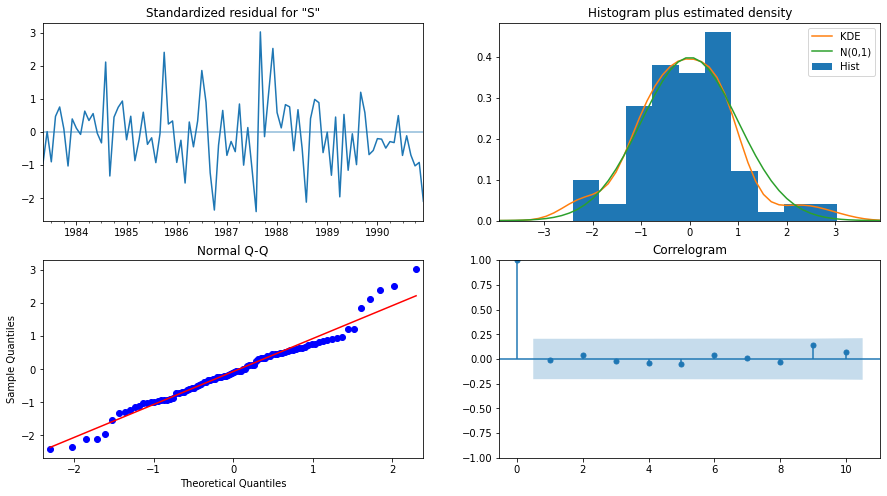

In [236]:
results_auto_SARIMA.plot_diagnostics();

In [237]:
predicted_auto_SARIMA = results_auto_SARIMA.get_forecast(steps=len(df_Test))

In [238]:
rmse_model7 = mean_squared_error(df_Test['Sparkling'],predicted_auto_SARIMA.predicted_mean,squared=False)

print("For Auto SARIMA Model forecast on the Training Data,  RMSE is %3.3f " %(rmse_model7))

For Auto ARIMA Model forecast on the Training Data,  RMSE is 611.271 


In [256]:
resultsDf_7 = pd.DataFrame({'Test RMSE': [rmse_model7]}
                           ,index=['AutoSARIMA(3, 1, 3)(3, 0, 0, 12)'])

resultsDf = pd.concat([resultsDf, resultsDf_7])


In [257]:
resultsDf

Test RMSE
Alpha=0.07,SES                         1338.008384
Alpha=.66,Beta=0.0001:DES              5291.879833
Alpha=0.11,Beta=0.012,Gamma=0.46:TES    378.626008
Alpha=0.71,Beta=0.049,Gamma=0.362:TES   402.938530
Linear Regression                      1386.836243
NaiveModel                             3864.279352
SimpleAverageModel                     1275.081804
2pointTrailingMovingAverage             813.400684
4pointTrailingMovingAverage            1156.589694
6pointTrailingMovingAverage            1283.927428
9pointTrailingMovingAverage            1346.278315
AutoARIMA(2,1,2)                       1299.979640
ManualARIMA(3,1,2)                     1286.234646
AutoSARIMA(3, 1, 3)(3, 0, 0, 12)        611.271445

In [228]:
# Build a version of the SARIMA model for which the best parameters are selected by looking at the ACF and the PACF plots. - Seasonality at 12.

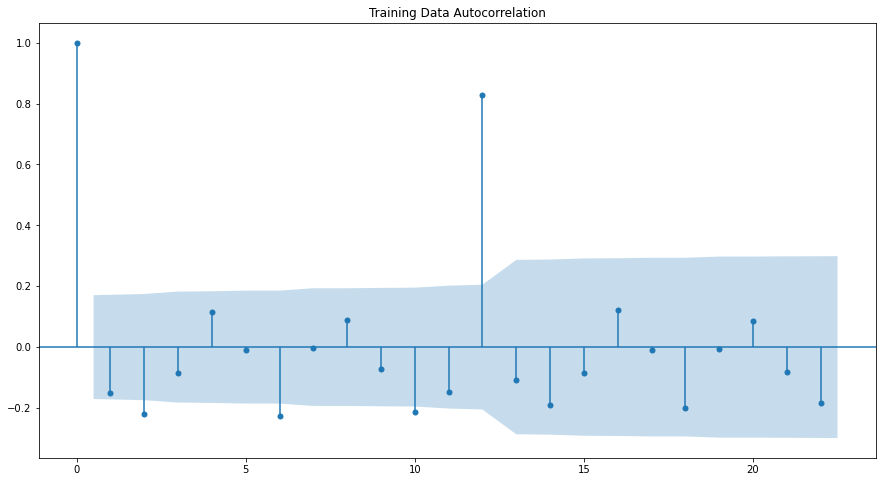

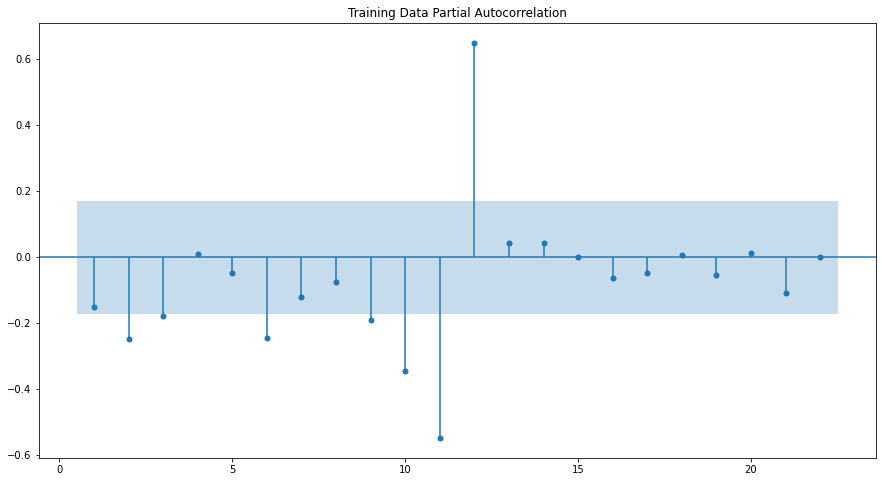

In [199]:
plot_acf(df_Train.diff(),title='Training Data Autocorrelation',missing='drop')
plot_pacf(df_Train.diff().dropna(),title='Training Data Partial Autocorrelation',zero=False,method='ywmle');

In [242]:
manual_SARIMA = sm.tsa.statespace.SARIMAX(df_Train['Sparkling'],
                                order=(3, 1, 2),
                                seasonal_order=(3, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_manual_SARIMA = manual_SARIMA.fit(maxiter=1000)
print(results_manual_SARIMA.summary())

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                       
Dep. Variable:                            Sparkling   No. Observations:                  132
Model:             SARIMAX(3, 1, 2)x(3, 0, [1], 12)   Log Likelihood                -684.301
Date:                              Wed, 15 Dec 2021   AIC                           1388.603
Time:                                      20:43:02   BIC                           1413.821
Sample:                                  01-01-1980   HQIC                          1398.781
                                       - 12-01-1990                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5430      0.416     -1.306      0.192      -1.358       0.272
ar.L2         -0.00

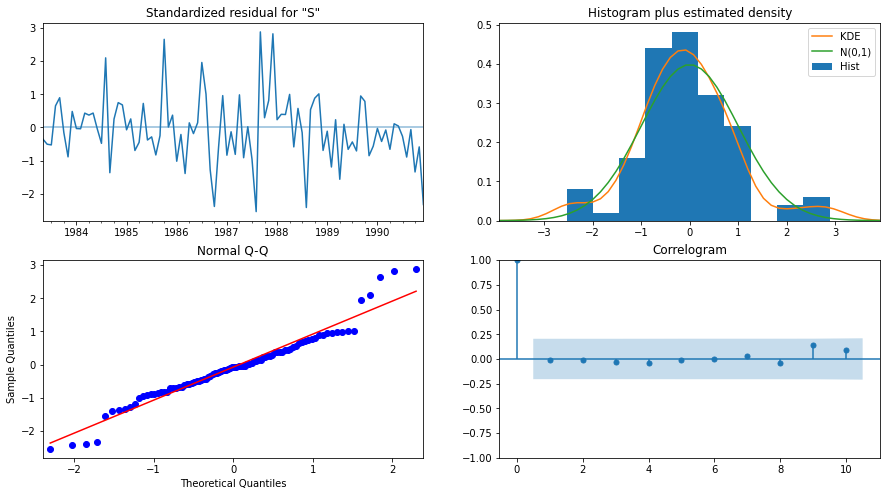

In [243]:
results_manual_SARIMA.plot_diagnostics();

In [244]:
predicted_manual_SARIMA = results_manual_SARIMA.get_forecast(steps=len(df_Test))

In [245]:
rmse_model8 = mean_squared_error(df_Test['Sparkling'],predicted_manual_SARIMA.predicted_mean,squared=False)

print("For Manual SARIMA Model forecast on the Training Data,  RMSE is %3.3f " %(rmse_model8))

For Manual ARIMA Model forecast on the Training Data,  RMSE is 579.536 


In [258]:
resultsDf_8 = pd.DataFrame({'Test RMSE': [rmse_model8]}
                           ,index=['ManualSARIMA(3, 1, 2)(3, 0, 1, 12)'])

resultsDf = pd.concat([resultsDf, resultsDf_8])


In [259]:
resultsDf

Test RMSE
Alpha=0.07,SES                         1338.008384
Alpha=.66,Beta=0.0001:DES              5291.879833
Alpha=0.11,Beta=0.012,Gamma=0.46:TES    378.626008
Alpha=0.71,Beta=0.049,Gamma=0.362:TES   402.938530
Linear Regression                      1386.836243
NaiveModel                             3864.279352
SimpleAverageModel                     1275.081804
2pointTrailingMovingAverage             813.400684
4pointTrailingMovingAverage            1156.589694
6pointTrailingMovingAverage            1283.927428
9pointTrailingMovingAverage            1346.278315
AutoARIMA(2,1,2)                       1299.979640
ManualARIMA(3,1,2)                     1286.234646
AutoSARIMA(3, 1, 3)(3, 0, 0, 12)        611.271445
ManualSARIMA(3, 1, 2)(3, 0, 1, 12)      579.536269

In [255]:
# Most optimum Model is Triple Exponential Smoothing or Holt-Winters Method.

In [ ]:
# Predicting next 12 months data

In [260]:
fullmodel1=ExponentialSmoothing(df,
                                  trend='additive',
                                  seasonal='additive').fit(smoothing_level=0.11,
                                                                 smoothing_trend=0.012,
                                                                 smoothing_seasonal=0.46)


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [261]:
RMSE_fullmodel1 = metrics.mean_squared_error(df['Sparkling'],fullmodel1.fittedvalues,squared=False)


In [262]:
print('RMSE:',RMSE_fullmodel1)

RMSE: 368.00814865080315


In [263]:
Future_forecast1 = fullmodel1.forecast(steps=12)

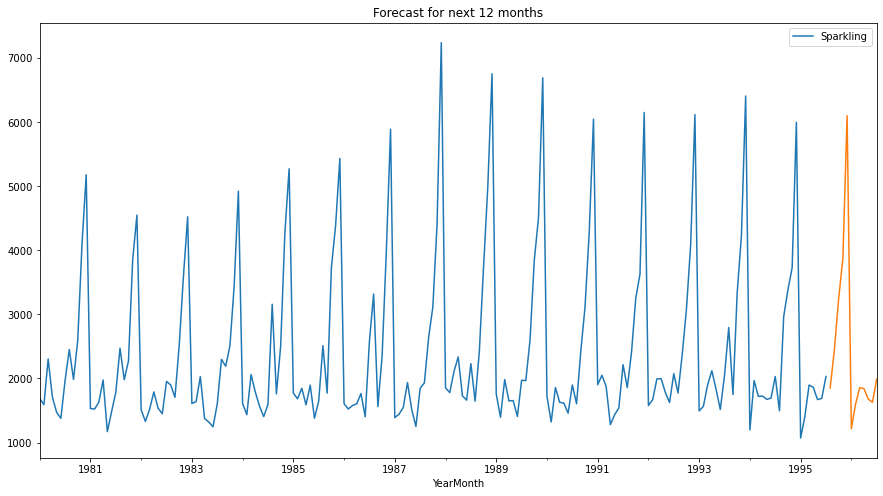

In [270]:
df.plot()
Future_forecast1.plot()
plt.title('Forecast for next 12 months');

## Rose Wine Data Analysis 

In [6]:
df2

Rose
YearMonth        
1980-01-01  112.0
1980-02-01  118.0
1980-03-01  129.0
1980-04-01   99.0
1980-05-01  116.0
...           ...
1995-03-01   45.0
1995-04-01   52.0
1995-05-01   28.0
1995-06-01   40.0
1995-07-01   62.0

[187 rows x 1 columns]

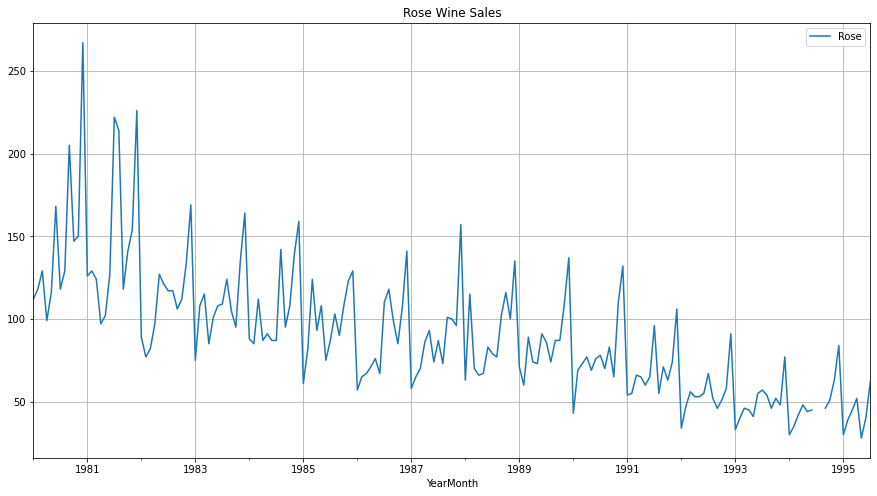

In [7]:
rcParams['figure.figsize']=15,8
df2.plot(grid=True)
plt.title('Rose Wine Sales');

In [8]:
df2[df2.index.year >= 1994]

Rose
YearMonth       
1994-01-01  30.0
1994-02-01  35.0
1994-03-01  42.0
1994-04-01  48.0
1994-05-01  44.0
1994-06-01  45.0
1994-07-01   NaN
1994-08-01   NaN
1994-09-01  46.0
1994-10-01  51.0
1994-11-01  63.0
1994-12-01  84.0
1995-01-01  30.0
1995-02-01  39.0
1995-03-01  45.0
1995-04-01  52.0
1995-05-01  28.0
1995-06-01  40.0
1995-07-01  62.0

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 1980-01-01 to 1995-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rose    185 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


In [10]:
# missing values 

In [11]:
#Interpolating Missing Values But Only Up Two Values coz only 2 values are missing

In [12]:
df3 = df2.interpolate(limit=2, limit_direction="forward");
df3[df3.index.year >= 1994]

Rose
YearMonth            
1994-01-01  30.000000
1994-02-01  35.000000
1994-03-01  42.000000
1994-04-01  48.000000
1994-05-01  44.000000
1994-06-01  45.000000
1994-07-01  45.333333
1994-08-01  45.666667
1994-09-01  46.000000
1994-10-01  51.000000
1994-11-01  63.000000
1994-12-01  84.000000
1995-01-01  30.000000
1995-02-01  39.000000
1995-03-01  45.000000
1995-04-01  52.000000
1995-05-01  28.000000
1995-06-01  40.000000
1995-07-01  62.000000

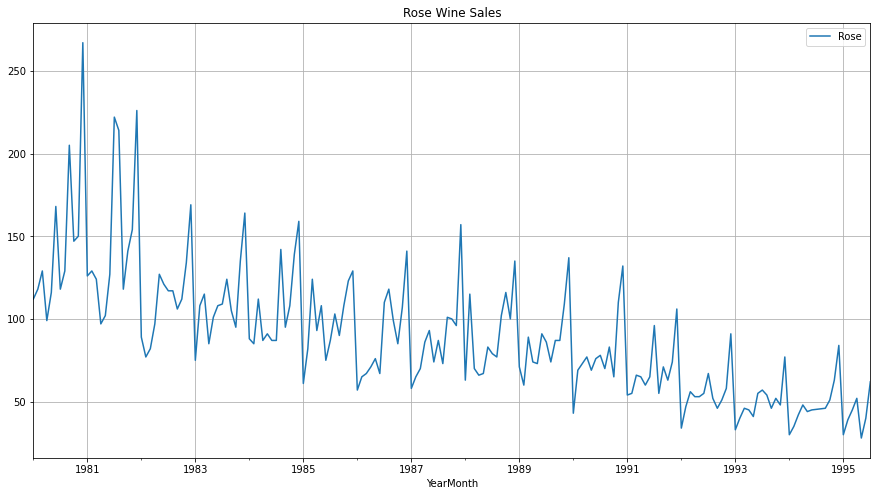

In [124]:
rcParams['figure.figsize']=15,8
df3.plot(grid=True)
plt.title('Rose Wine Sales');

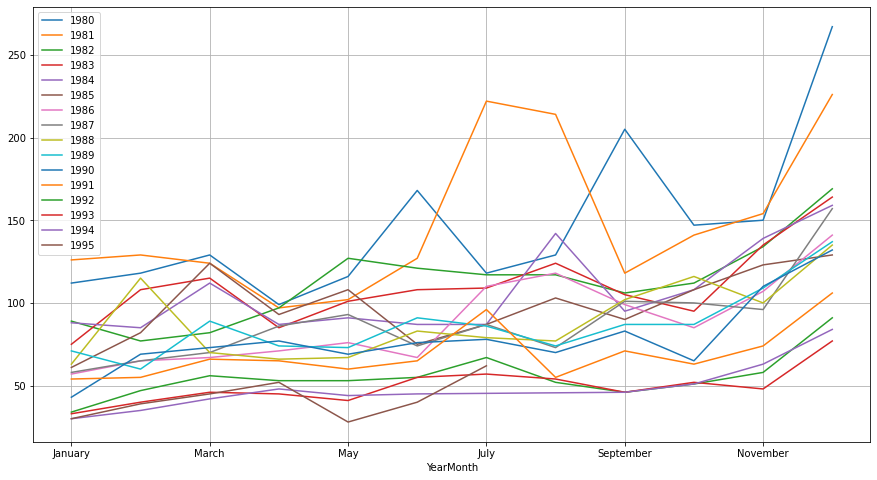

In [13]:
months=['January','February','March','April','May','June','July', 'August','September','October','November','December']
yearly_sales_across_years1=pd.pivot_table(df3,values='Rose',columns=df3.index.year,index=df3.index.month_name())
yearly_sales_across_years1=yearly_sales_across_years1.reindex(index=months)
yearly_sales_across_years1.plot()
plt.grid()
plt.legend(loc='best');


In [14]:
#Plot a boxplot to understand the spread of sales across different years and within different months across years.

In [15]:
#Yearly Boxplot

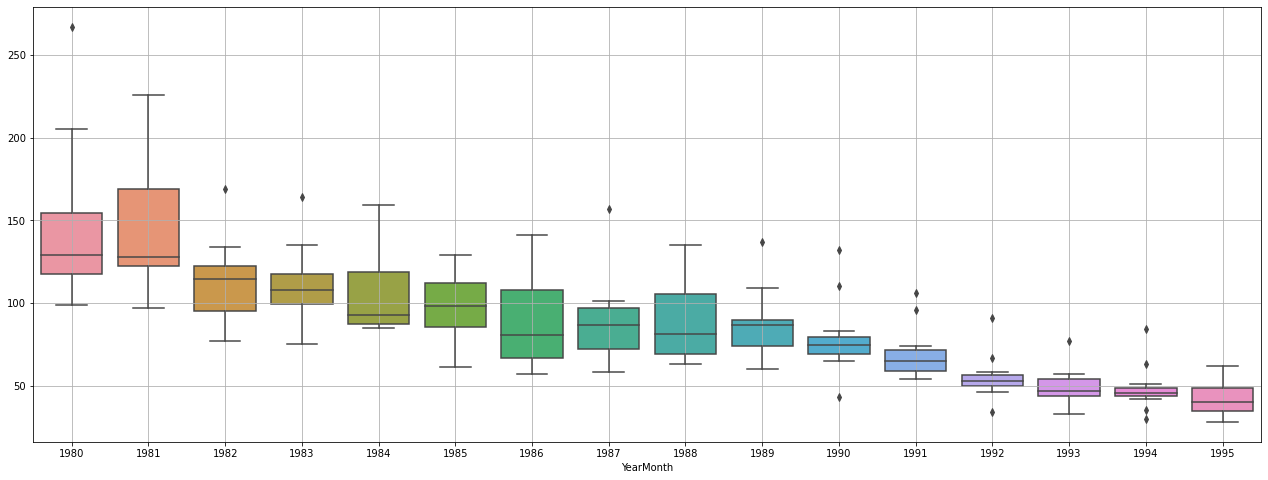

In [16]:
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = df3.index.year,y = df3.values[:,0],ax=ax)
plt.grid();

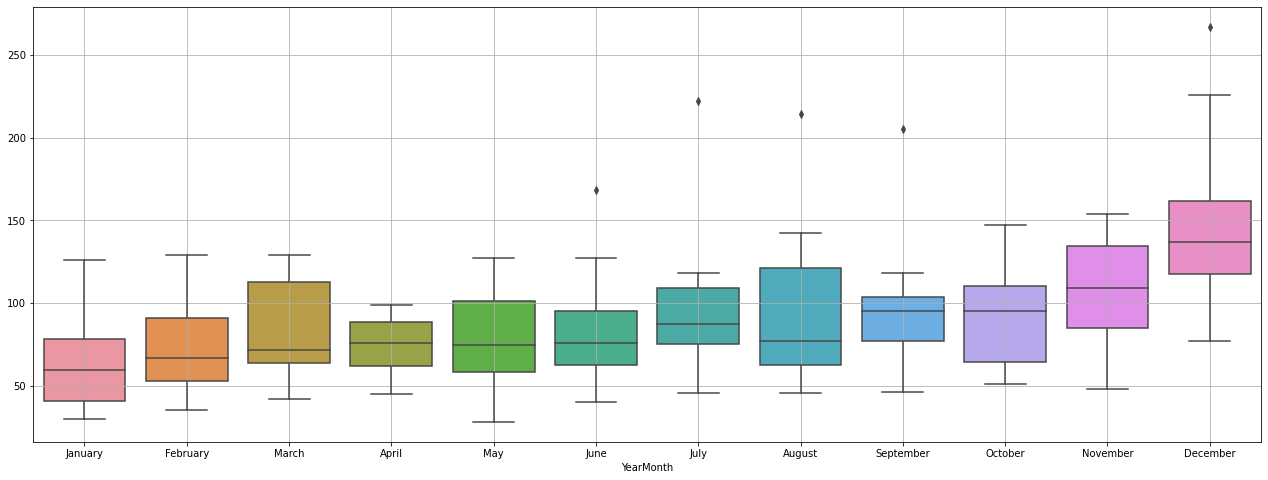

In [17]:

# Monthly Plot
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = df3.index.month_name(),y = df3.values[:,0],ax=ax)
plt.grid();

In [18]:
### Decomposition of Rose Data set

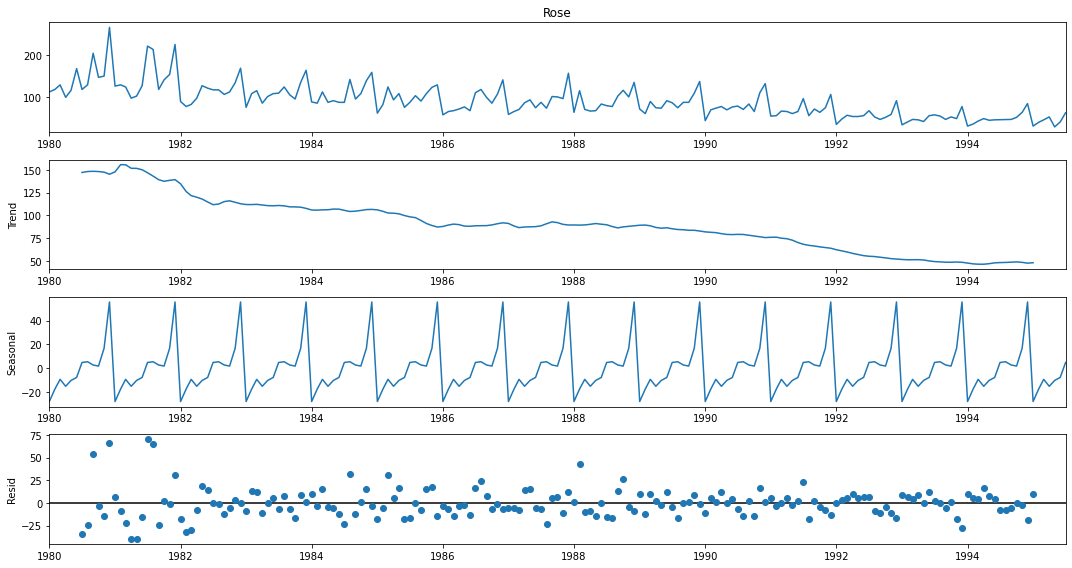

In [19]:
decomposition_df2=seasonal_decompose(df3['Rose'],model='additive')
decomposition_df2.plot();

In [20]:
df3_Train =df3[df3.index.year <=1990]
df3_Test =df3[df3.index.year >1990]

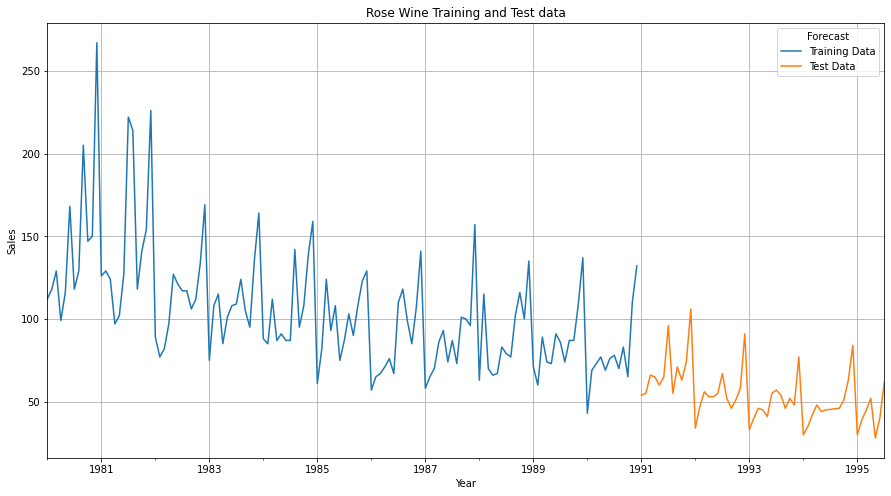

In [21]:
df3_Train['Rose'].plot()
df3_Test['Rose'].plot()
plt.grid()
plt.title('Rose Wine Training and Test data')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend(['Training Data','Test Data'],title='Forecast');


In [22]:
#SES - ETS(A, N, N) - Simple Exponential Smoothing with additive errors
model_SES1 = SimpleExpSmoothing(df3_Train,initialization_method='estimated')

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [23]:
model_SES_autofit1 = model_SES1.fit(optimized=True)

In [24]:
model_SES_autofit1.params

{'smoothing_level': 0.09874983698117956,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 134.38702481818487,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [25]:
SES_predict1 = model_SES_autofit1.forecast(steps=len(df3_Test))
SES_predict1

1991-01-01    87.104997
1991-02-01    87.104997
1991-03-01    87.104997
1991-04-01    87.104997
1991-05-01    87.104997
1991-06-01    87.104997
1991-07-01    87.104997
1991-08-01    87.104997
1991-09-01    87.104997
1991-10-01    87.104997
1991-11-01    87.104997
1991-12-01    87.104997
1992-01-01    87.104997
1992-02-01    87.104997
1992-03-01    87.104997
1992-04-01    87.104997
1992-05-01    87.104997
1992-06-01    87.104997
1992-07-01    87.104997
1992-08-01    87.104997
1992-09-01    87.104997
1992-10-01    87.104997
1992-11-01    87.104997
1992-12-01    87.104997
1993-01-01    87.104997
1993-02-01    87.104997
1993-03-01    87.104997
1993-04-01    87.104997
1993-05-01    87.104997
1993-06-01    87.104997
1993-07-01    87.104997
1993-08-01    87.104997
1993-09-01    87.104997
1993-10-01    87.104997
1993-11-01    87.104997
1993-12-01    87.104997
1994-01-01    87.104997
1994-02-01    87.104997
1994-03-01    87.104997
1994-04-01    87.104997
1994-05-01    87.104997
1994-06-01    87

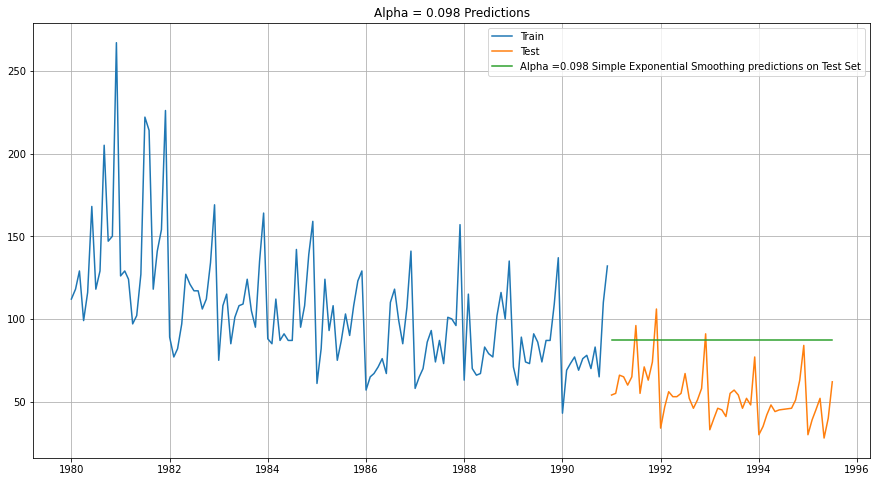

In [26]:
plt.plot(df3_Train, label='Train')
plt.plot(df3_Test, label='Test')

plt.plot(SES_predict1, label='Alpha =0.098 Simple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Alpha = 0.098 Predictions');

In [27]:
def MAPE(y_true, y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100

In [28]:
print('SES RMSE:',mean_squared_error(df3_Test.values,SES_predict1.values,squared=False))
#different way to calculate RMSE
import statsmodels.tools.eval_measures as      em
print('SES RMSE (calculated using statsmodels):',em.rmse(df3_Test.values,SES_predict1.values)[0])

SES RMSE: 36.79624054770398
SES RMSE (calculated using statsmodels): 36.796240547703974


In [29]:
resultsDf1 = pd.DataFrame({'Test RMSE': [em.rmse(df3_Test.values,SES_predict1.values)[0]]},index=['Alpha=0.098,SES'])
resultsDf1

Test RMSE
Alpha=0.098,SES  36.796241

In [30]:
# Holt - ETS(A, A, N) - Holt's linear method with additive errors

In [31]:
model_DES1 = Holt(df3_Train,initialization_method='estimated')
# Fitting the model
model_DES1 = model_DES1.fit()

print('')
print('==Holt model Exponential Smoothing Estimated Parameters ==')
print('')
print(model_DES1.params)


==Holt model Exponential Smoothing Estimated Parameters ==

{'smoothing_level': 1.4901161193847656e-08, 'smoothing_trend': 1.6610391146660035e-10, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 137.81553690867275, 'initial_trend': -0.4943781897068274, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [32]:
DES_predict1 =  model_DES1.forecast(len(df3_Test))
DES_predict1

1991-01-01    72.063238
1991-02-01    71.568859
1991-03-01    71.074481
1991-04-01    70.580103
1991-05-01    70.085725
1991-06-01    69.591347
1991-07-01    69.096969
1991-08-01    68.602590
1991-09-01    68.108212
1991-10-01    67.613834
1991-11-01    67.119456
1991-12-01    66.625078
1992-01-01    66.130699
1992-02-01    65.636321
1992-03-01    65.141943
1992-04-01    64.647565
1992-05-01    64.153187
1992-06-01    63.658808
1992-07-01    63.164430
1992-08-01    62.670052
1992-09-01    62.175674
1992-10-01    61.681296
1992-11-01    61.186918
1992-12-01    60.692539
1993-01-01    60.198161
1993-02-01    59.703783
1993-03-01    59.209405
1993-04-01    58.715027
1993-05-01    58.220648
1993-06-01    57.726270
1993-07-01    57.231892
1993-08-01    56.737514
1993-09-01    56.243136
1993-10-01    55.748757
1993-11-01    55.254379
1993-12-01    54.760001
1994-01-01    54.265623
1994-02-01    53.771245
1994-03-01    53.276866
1994-04-01    52.782488
1994-05-01    52.288110
1994-06-01    51

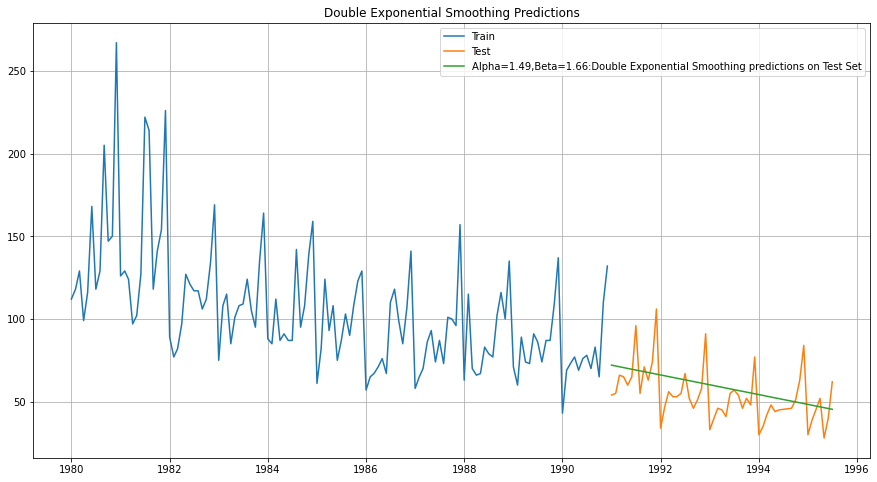

In [33]:
plt.plot(df3_Train, label='Train')
plt.plot(df3_Test, label='Test')

#plt.plot(SES_predict, label='Alpha=0.07:Simple Exponential Smoothing predictions on Test Set')
plt.plot(DES_predict1, label='Alpha=1.49,Beta=1.66:Double Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Double Exponential Smoothing Predictions');

In [34]:
print('DES RMSE:',mean_squared_error(df3_Test.values,DES_predict1.values,squared=False))

DES RMSE: 15.268943764436564


In [35]:
resultsDf_DES1 = pd.DataFrame({'Test RMSE': [mean_squared_error(df3_Test.values,DES_predict1.values,squared=False)]}
                           ,index=['Alpha=1.49,Beta=1.66:DES'])

resultsDf1 = pd.concat([resultsDf1, resultsDf_DES1])

In [36]:
resultsDf1 

Test RMSE
Alpha=0.098,SES           36.796241
Alpha=1.49,Beta=1.66:DES  15.268944

In [37]:
#Holt-Winters - ETS(A, A, A) - Holt Winter's linear method with additive errors

In [38]:
model_TES1 = ExponentialSmoothing(df3_Train,trend='additive',seasonal='additive',initialization_method='estimated')
# Fitting the model
model_TES1 = model_TES1.fit()

print('')
print('==Holt Winters model Exponential Smoothing Estimated Parameters ==')
print('')
print(model_TES1.params)

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'



==Holt Winters model Exponential Smoothing Estimated Parameters ==

{'smoothing_level': 0.08872764725999983, 'smoothing_trend': 9.006425383910208e-06, 'smoothing_seasonal': 0.00030220468692033857, 'damping_trend': nan, 'initial_level': 146.86313344217183, 'initial_trend': -0.54920783338383, 'initial_seasons': array([-31.29615978, -18.85729122, -10.84129035, -21.39327001,
       -12.61174453,  -7.17892692,   2.72463253,   8.78522404,
         4.87498352,   3.01144155,  21.09509348,  63.26062685]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [39]:
TES_predict1 =  model_TES1.forecast(len(df3_Test))
TES_predict1

1991-01-01     42.493878
1991-02-01     54.383286
1991-03-01     61.850018
1991-04-01     50.748583
1991-05-01     58.981025
1991-06-01     63.864702
1991-07-01     73.219078
1991-08-01     78.730554
1991-09-01     74.270845
1991-10-01     71.857980
1991-11-01     89.392486
1991-12-01    131.011001
1992-01-01     35.903382
1992-02-01     47.792789
1992-03-01     55.259522
1992-04-01     44.158086
1992-05-01     52.390528
1992-06-01     57.274205
1992-07-01     66.628582
1992-08-01     72.140058
1992-09-01     67.680349
1992-10-01     65.267484
1992-11-01     82.801990
1992-12-01    124.420505
1993-01-01     29.312885
1993-02-01     41.202293
1993-03-01     48.669026
1993-04-01     37.567590
1993-05-01     45.800032
1993-06-01     50.683709
1993-07-01     60.038085
1993-08-01     65.549561
1993-09-01     61.089852
1993-10-01     58.676987
1993-11-01     76.211493
1993-12-01    117.830009
1994-01-01     22.722389
1994-02-01     34.611797
1994-03-01     42.078529
1994-04-01     30.977093


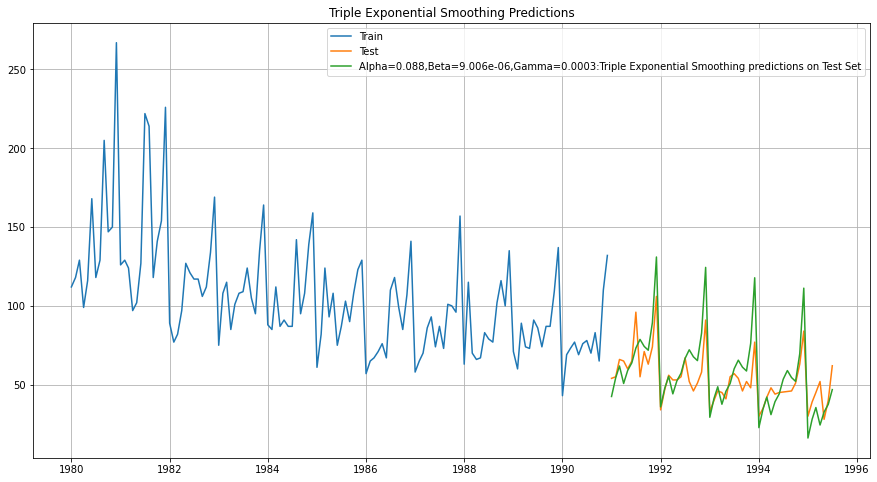

In [40]:
plt.plot(df3_Train, label='Train')
plt.plot(df3_Test, label='Test')

plt.plot(TES_predict1, label='Alpha=0.088,Beta=9.006e-06,Gamma=0.0003:Triple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Triple Exponential Smoothing Predictions');

In [41]:
print('TES RMSE:',mean_squared_error(df3_Test.values,TES_predict1.values,squared=False))

TES RMSE: 14.25561890068539


In [42]:
resultsDf_TES1 = pd.DataFrame({'Test RMSE': [mean_squared_error(df3_Test.values,TES_predict1.values,squared=False)]}
                           ,index=['Alpha=0.088,Beta=9.006e-06,Gamma=0.0003:TES'])

resultsDf1 = pd.concat([resultsDf1, resultsDf_TES1])


In [43]:
resultsDf1

Test RMSE
Alpha=0.098,SES                              36.796241
Alpha=1.49,Beta=1.66:DES                     15.268944
Alpha=0.088,Beta=9.006e-06,Gamma=0.0003:TES  14.255619

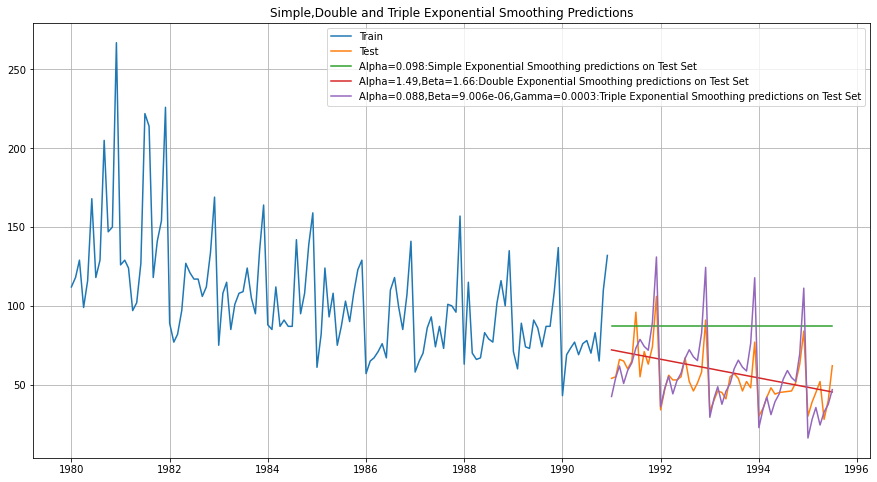

In [44]:
plt.plot(df3_Train, label='Train')
plt.plot(df3_Test, label='Test')

plt.plot(SES_predict1, label='Alpha=0.098:Simple Exponential Smoothing predictions on Test Set')
plt.plot(DES_predict1, label='Alpha=1.49,Beta=1.66:Double Exponential Smoothing predictions on Test Set')
plt.plot(TES_predict1, label='Alpha=0.088,Beta=9.006e-06,Gamma=0.0003:Triple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Simple,Double and Triple Exponential Smoothing Predictions');

In [45]:
#Holt-Winters - ETS(A, A, M) - Holt Winter's linear method

In [46]:
model_TES_am1 = ExponentialSmoothing(df3_Train,trend='add',seasonal='multiplicative',initialization_method='estimated')
# Fitting the model
model_TES_am1 = model_TES_am1.fit()

print('')
print('==Holt Winters model Exponential Smoothing Estimated Parameters ==')
print('')
print(model_TES_am1.params)

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'



==Holt Winters model Exponential Smoothing Estimated Parameters ==

{'smoothing_level': 0.07580378115501289, 'smoothing_trend': 0.04082731831671567, 'smoothing_seasonal': 0.0008792861232047841, 'damping_trend': nan, 'initial_level': 163.87796236599962, 'initial_trend': -0.9559811417358383, 'initial_seasons': array([0.68432572, 0.77587329, 0.84828062, 0.74119702, 0.83386517,
       0.90761668, 0.99838676, 1.06374484, 1.00486364, 0.9847888 ,
       1.14803087, 1.58276201]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [47]:
TES_predict_am1 =  model_TES_am1.forecast(len(df3_Test))
TES_predict_am1

1991-01-01     56.036899
1991-02-01     63.349325
1991-03-01     69.021015
1991-04-01     60.120355
1991-05-01     67.380193
1991-06-01     73.053471
1991-07-01     80.089604
1991-08-01     85.028307
1991-09-01     80.074762
1991-10-01     78.207855
1991-11-01     90.863516
1991-12-01    124.781088
1992-01-01     53.763924
1992-02-01     60.771028
1992-03-01     66.202322
1992-04-01     57.656765
1992-05-01     64.609652
1992-06-01     70.039327
1992-07-01     76.773753
1992-08-01     81.495797
1992-09-01     76.736490
1992-10-01     74.936046
1992-11-01     87.048962
1992-12-01    119.524246
1993-01-01     51.490950
1993-02-01     58.192732
1993-03-01     63.383629
1993-04-01     55.193175
1993-05-01     61.839110
1993-06-01     67.025183
1993-07-01     73.457901
1993-08-01     77.963287
1993-09-01     73.398218
1993-10-01     71.664238
1993-11-01     83.234408
1993-12-01    114.267403
1994-01-01     49.217976
1994-02-01     55.614435
1994-03-01     60.564937
1994-04-01     52.729585


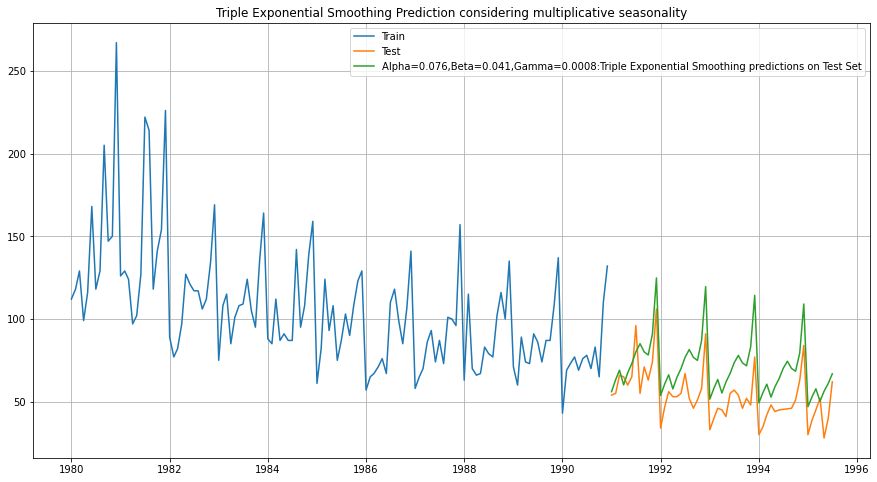

In [48]:
plt.plot(df3_Train, label='Train')
plt.plot(df3_Test, label='Test')

plt.plot(TES_predict_am1, label='Alpha=0.076,Beta=0.041,Gamma=0.0008:Triple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Triple Exponential Smoothing Prediction considering multiplicative seasonality');

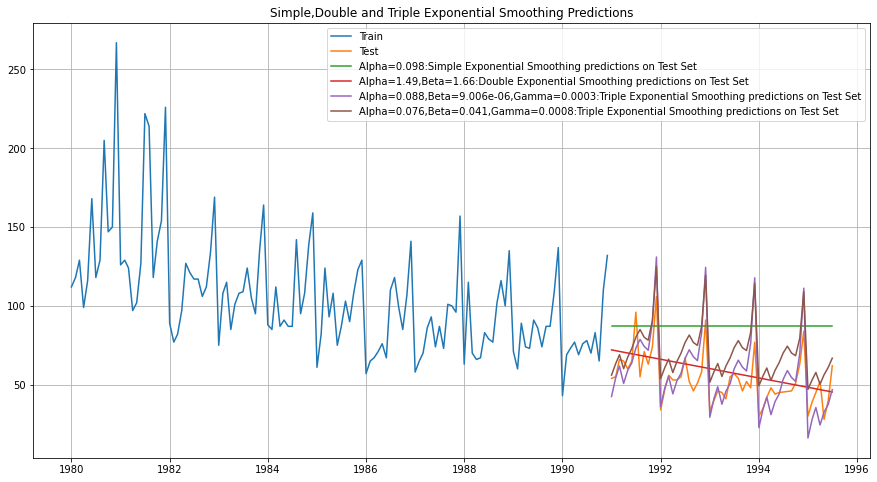

In [49]:
plt.plot(df3_Train, label='Train')
plt.plot(df3_Test, label='Test')

plt.plot(SES_predict1, label='Alpha=0.098:Simple Exponential Smoothing predictions on Test Set')
plt.plot(DES_predict1, label='Alpha=1.49,Beta=1.66:Double Exponential Smoothing predictions on Test Set')
plt.plot(TES_predict1, label='Alpha=0.088,Beta=9.006e-06,Gamma=0.0003:Triple Exponential Smoothing predictions on Test Set')
plt.plot(TES_predict_am1, label='Alpha=0.076,Beta=0.041,Gamma=0.0008:Triple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Simple,Double and Triple Exponential Smoothing Predictions');

In [50]:
print('TES_am RMSE:',mean_squared_error(df3_Test.values,TES_predict_am1.values,squared=False))

TES_am RMSE: 19.39714270628386


In [51]:
resultsDf_TES_am1 = pd.DataFrame({'Test RMSE': [mean_squared_error(df3_Test.values,TES_predict_am1.values,squared=False)]}
                           ,index=['Alpha=0.076,Beta=0.041,Gamma=0.0008:TESm'])

resultsDf1 = pd.concat([resultsDf1, resultsDf_TES_am1])
resultsDf1

Test RMSE
Alpha=0.098,SES                              36.796241
Alpha=1.49,Beta=1.66:DES                     15.268944
Alpha=0.088,Beta=9.006e-06,Gamma=0.0003:TES  14.255619
Alpha=0.076,Beta=0.041,Gamma=0.0008:TESm     19.397143

In [52]:
# Building different models and comparing the accuracy metrics.

In [53]:
# Model 1: Linear Regression

In [54]:
len(df3_Train)

132

In [55]:
train_time1 = [i+1 for i in range(len(df3_Train))]
test_time1 = [i+132 for i in range(len(df3_Test))]

In [56]:
LinearRegression_train1 = df3_Train.copy()
LinearRegression_test1 = df3_Test.copy()

In [57]:
LinearRegression_train1['time'] = train_time1
LinearRegression_test1['time'] = test_time1

In [58]:
from sklearn.linear_model import LinearRegression

In [59]:
lr1 = LinearRegression()

In [60]:
lr1.fit(LinearRegression_train1[['time']],LinearRegression_train1['Rose'].values)

LinearRegression()

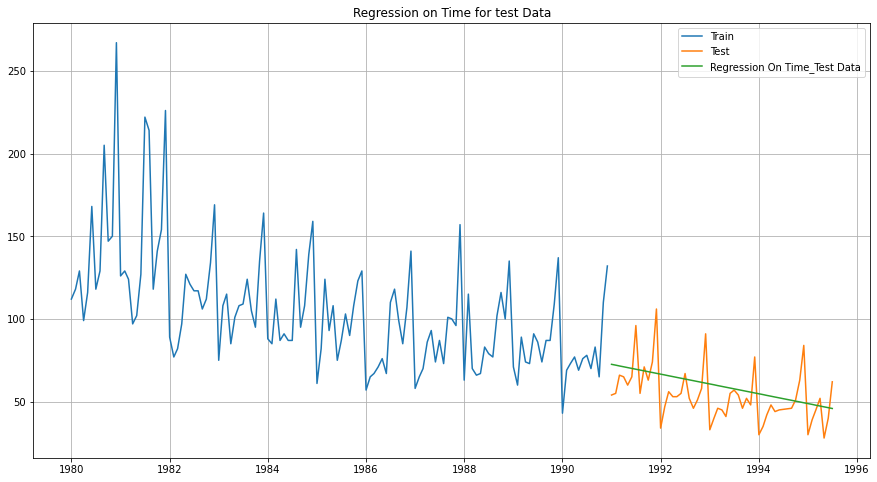

In [61]:
test_predictions_model2 = lr1.predict(LinearRegression_test1[['time']])
LinearRegression_test1['RegOnTime'] = test_predictions_model2


plt.plot( df3_Train['Rose'], label='Train')
plt.plot(df3_Test['Rose'], label='Test')
plt.plot(LinearRegression_test1['RegOnTime'], label='Regression On Time_Test Data')
plt.legend(loc='best')
plt.title('Regression on Time for test Data')
plt.grid();

In [62]:
from sklearn import metrics
print("For RegressionOnTime forecast on the Test Data,  RMSE is %3.3f" %(metrics.mean_squared_error(df3_Test['Rose'],test_predictions_model2,squared=False)))

For RegressionOnTime forecast on the Test Data,  RMSE is 15.433


In [63]:
resultsDf_Reg1 = pd.DataFrame({'Test RMSE': [mean_squared_error(df3_Test['Rose'],test_predictions_model2,squared=False)]},index=['Linear Regression'])

resultsDf1 = pd.concat([resultsDf1, resultsDf_Reg1])
resultsDf1

Test RMSE
Alpha=0.098,SES                              36.796241
Alpha=1.49,Beta=1.66:DES                     15.268944
Alpha=0.088,Beta=9.006e-06,Gamma=0.0003:TES  14.255619
Alpha=0.076,Beta=0.041,Gamma=0.0008:TESm     19.397143
Linear Regression                            15.433446

In [64]:
# Model 2: Naive Approach

In [65]:
NaiveModel_train1 = df3_Train.copy()
NaiveModel_test1 = df3_Test.copy()

In [66]:
NaiveModel_test1['naive'] = np.asarray(NaiveModel_train1['Rose'])[len(np.asarray(NaiveModel_train1['Rose']))-1]
NaiveModel_test1['naive'].head()

YearMonth
1991-01-01    132.0
1991-02-01    132.0
1991-03-01    132.0
1991-04-01    132.0
1991-05-01    132.0
Name: naive, dtype: float64

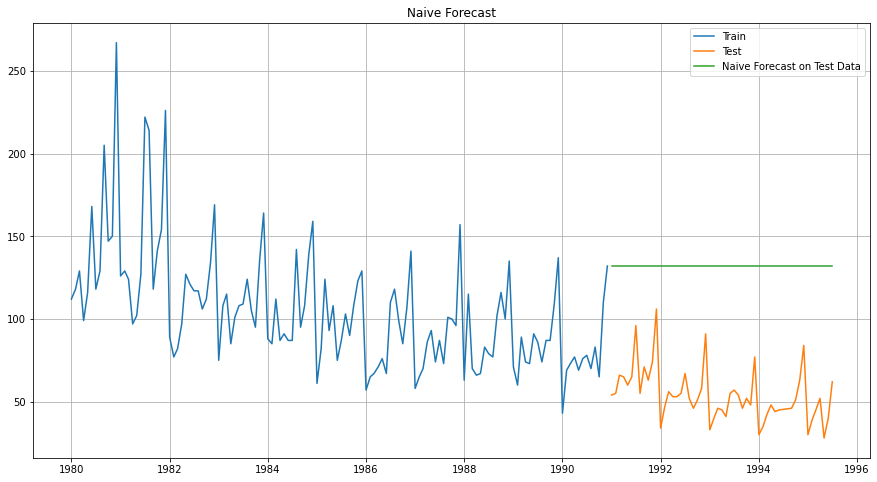

In [67]:
plt.plot(NaiveModel_train1['Rose'], label='Train')
plt.plot(NaiveModel_test1['Rose'], label='Test')
plt.plot(NaiveModel_test1['naive'], label='Naive Forecast on Test Data')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.grid();

In [68]:
rmse_model2_test1 = metrics.mean_squared_error(NaiveModel_test1['Rose'],NaiveModel_test1['naive'],squared=False)
print("For Naive Model forecast on the Test Data,  RMSE is %3.3f" %(rmse_model2_test1))

For Naive Model forecast on the Test Data,  RMSE is 79.719


In [69]:
resultsDf_naive1 = pd.DataFrame({'Test RMSE': [rmse_model2_test1]},index=['NaiveModel'])

resultsDf1 = pd.concat([resultsDf1, resultsDf_naive1])
resultsDf1

Test RMSE
Alpha=0.098,SES                              36.796241
Alpha=1.49,Beta=1.66:DES                     15.268944
Alpha=0.088,Beta=9.006e-06,Gamma=0.0003:TES  14.255619
Alpha=0.076,Beta=0.041,Gamma=0.0008:TESm     19.397143
Linear Regression                            15.433446
NaiveModel                                   79.718773

In [70]:
# Method 3: Simple Average

In [71]:
SimpleAverage_train1 = df3_Train.copy()
SimpleAverage_test1 = df3_Test.copy()

In [72]:
SimpleAverage_test1['mean_forecast'] = SimpleAverage_train1['Rose'].mean()
SimpleAverage_test1.head()

Rose  mean_forecast
YearMonth                      
1991-01-01  54.0     104.939394
1991-02-01  55.0     104.939394
1991-03-01  66.0     104.939394
1991-04-01  65.0     104.939394
1991-05-01  60.0     104.939394

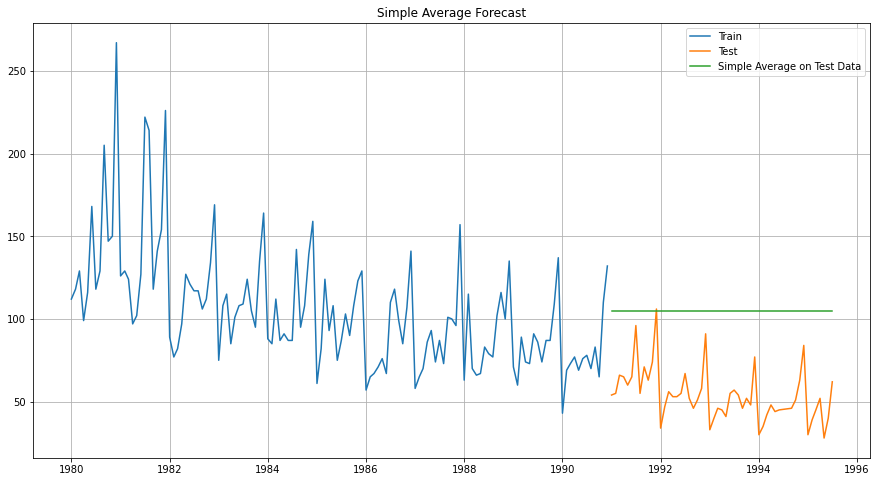

In [73]:
plt.plot(SimpleAverage_train1['Rose'], label='Train')
plt.plot(SimpleAverage_test1['Rose'], label='Test')
plt.plot(SimpleAverage_test1['mean_forecast'], label='Simple Average on Test Data')
plt.legend(loc='best')
plt.title("Simple Average Forecast")
plt.grid();

In [74]:
rmse_model3_test1 = metrics.mean_squared_error(SimpleAverage_test1['Rose'],SimpleAverage_test1['mean_forecast'],squared=False)
print("For Simple Average forecast on the Test Data,  RMSE is %3.3f" %(rmse_model3_test1))

For Simple Average forecast on the Test Data,  RMSE is 53.461


In [75]:
resultsDf_Simple1 = pd.DataFrame({'Test RMSE': [rmse_model3_test1]},index=['SimpleAverageModel'])

resultsDf1 = pd.concat([resultsDf1, resultsDf_Simple1])
resultsDf1

Test RMSE
Alpha=0.098,SES                              36.796241
Alpha=1.49,Beta=1.66:DES                     15.268944
Alpha=0.088,Beta=9.006e-06,Gamma=0.0003:TES  14.255619
Alpha=0.076,Beta=0.041,Gamma=0.0008:TESm     19.397143
Linear Regression                            15.433446
NaiveModel                                   79.718773
SimpleAverageModel                           53.460570

In [76]:
#Method 4: Moving Average(MA)

In [77]:
MovingAverage1 = df3.copy()
MovingAverage1.head()

Rose
YearMonth        
1980-01-01  112.0
1980-02-01  118.0
1980-03-01  129.0
1980-04-01   99.0
1980-05-01  116.0

In [78]:
MovingAverage1['Trailing_2'] = MovingAverage1['Rose'].rolling(2).mean()
MovingAverage1['Trailing_4'] = MovingAverage1['Rose'].rolling(4).mean()
MovingAverage1['Trailing_6'] = MovingAverage1['Rose'].rolling(6).mean()

MovingAverage1.head()

Rose  Trailing_2  Trailing_4  Trailing_6
YearMonth                                            
1980-01-01  112.0         NaN         NaN         NaN
1980-02-01  118.0       115.0         NaN         NaN
1980-03-01  129.0       123.5         NaN         NaN
1980-04-01   99.0       114.0       114.5         NaN
1980-05-01  116.0       107.5       115.5         NaN

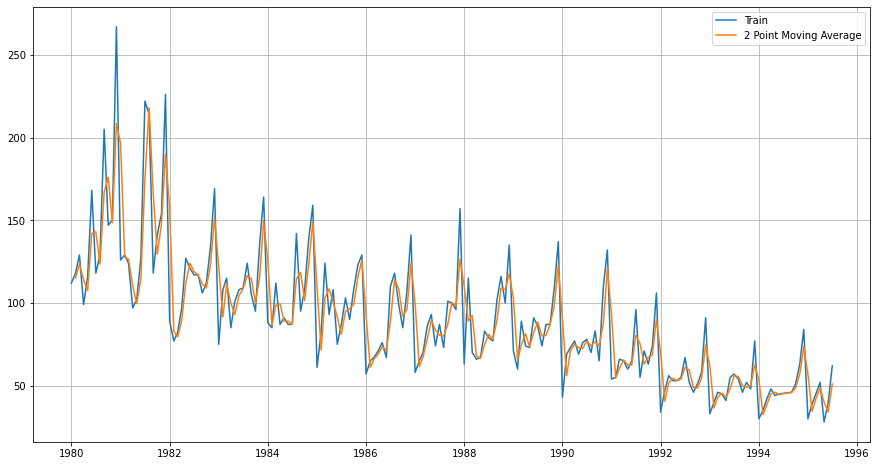

In [126]:
plt.plot(MovingAverage1['Rose'], label='Train')
plt.plot(MovingAverage1['Trailing_2'], label='2 Point Moving Average')
plt.plot(MovingAverage1['Trailing_4'], label='4 Point Moving Average')
plt.plot(MovingAverage1['Trailing_6'],label = '6 Point Moving Average')

plt.legend(loc = 'best')
plt.grid();

In [125]:
df3.tail()

Rose
YearMonth       
1995-03-01  45.0
1995-04-01  52.0
1995-05-01  28.0
1995-06-01  40.0
1995-07-01  62.0

In [80]:
trailing_MovingAverage_train1=MovingAverage1[MovingAverage1.index.year<= 1990] 
trailing_MovingAverage_test1=MovingAverage1[MovingAverage1.index.year>1990]

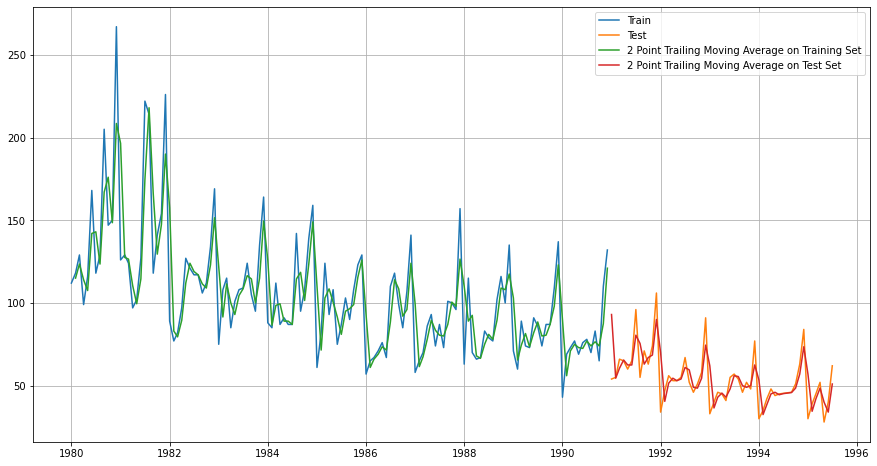

In [127]:
plt.plot(trailing_MovingAverage_train1['Rose'], label='Train')
plt.plot(trailing_MovingAverage_test1['Rose'], label='Test')

plt.plot(trailing_MovingAverage_train1['Trailing_2'], label='2 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train1['Trailing_4'], label='4 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train1['Trailing_6'],label = '6 Point Trailing Moving Average on Training Set')

plt.plot(trailing_MovingAverage_test1['Trailing_2'], label='2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test1['Trailing_4'], label='4 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test1['Trailing_6'],label = '6 Point Trailing Moving Average on Test Set')

plt.legend(loc = 'best')
plt.grid();

In [82]:
## Test Data - RMSE --> 2 point Trailing MA

rmse_model4_test_2_1 = metrics.mean_squared_error(trailing_MovingAverage_test1['Rose'],trailing_MovingAverage_test1['Trailing_2'],squared=False)
print("For 2 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_2_1))

## Test Data - RMSE  --> 4 point Trailing MA

rmse_model4_test_4_1 = metrics.mean_squared_error(trailing_MovingAverage_test1['Rose'],trailing_MovingAverage_test1['Trailing_4'],squared=False)
print("For 4 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_4_1))

## Test Data - RMSE --> 6 point Trailing MA

rmse_model4_test_6_1 = metrics.mean_squared_error(trailing_MovingAverage_test1['Rose'],trailing_MovingAverage_test1['Trailing_6'],squared=False)
print("For 6 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_6_1))


For 2 point Moving Average Model forecast on the Training Data,  RMSE is 11.529
For 4 point Moving Average Model forecast on the Training Data,  RMSE is 14.451
For 6 point Moving Average Model forecast on the Training Data,  RMSE is 14.566


In [83]:
resultsDf_4_1 = pd.DataFrame({'Test RMSE': [rmse_model4_test_2_1,rmse_model4_test_4_1
                                          ,rmse_model4_test_6_1]}
                           ,index=['2pointTrailingMovingAverage','4pointTrailingMovingAverage'
                                   ,'6pointTrailingMovingAverage'])

resultsDf1 = pd.concat([resultsDf1, resultsDf_4_1])
resultsDf1

Test RMSE
Alpha=0.098,SES                              36.796241
Alpha=1.49,Beta=1.66:DES                     15.268944
Alpha=0.088,Beta=9.006e-06,Gamma=0.0003:TES  14.255619
Alpha=0.076,Beta=0.041,Gamma=0.0008:TESm     19.397143
Linear Regression                            15.433446
NaiveModel                                   79.718773
SimpleAverageModel                           53.460570
2pointTrailingMovingAverage                  11.529278
4pointTrailingMovingAverage                  14.451403
6pointTrailingMovingAverage                  14.566327

In [84]:
# Check for the stationarity of the data
#Augmented  Dickey-Fuller  Test: A  formal  test  to  check  whether  time  series  data  follows stationary process.
#H0: Time series is non-stationary
#H1: Time series is stationary

In [85]:
dftest1=adfuller(df3_Train,regression='ct',autolag=None,maxlag=24)
print('DF test statistic is %3.3f'%dftest1[0])
print('DF test p-value is',dftest1[1])
print('Number of lags used',dftest1[2])

DF test statistic is -3.160
DF test p-value is 0.09272983310684335
Number of lags used 24


In [86]:
# Sales is not Stationary

In [87]:
df3_Train_log=np.log10(df3_Train)
dftest1=adfuller(df3_Train_log,regression='ct',autolag=None,maxlag=24)
print('DF test statistic is %3.3f'%dftest1[0])
print('DF test p-value is',dftest1[1])
print('Number of lags used',dftest1[2])

DF test statistic is -2.645
DF test p-value is 0.25968786910763036
Number of lags used 24


In [88]:
#Neither  original  nor  log-transformed  series  is  stationary.  Hence, a  stationarization  is necessary.
#Often differencing a non-stationary time series leadsto a stationary series.

In [89]:
dftest1 = adfuller(df3_Train.diff().dropna(),regression='ct')
print('DF test statistic is %3.3f' %dftest1[0])
print('DF test p-value is' ,dftest1[1])
print('Number of lags used' ,dftest1[2])

DF test statistic is -6.804
DF test p-value is 3.894831356782412e-08
Number of lags used 12


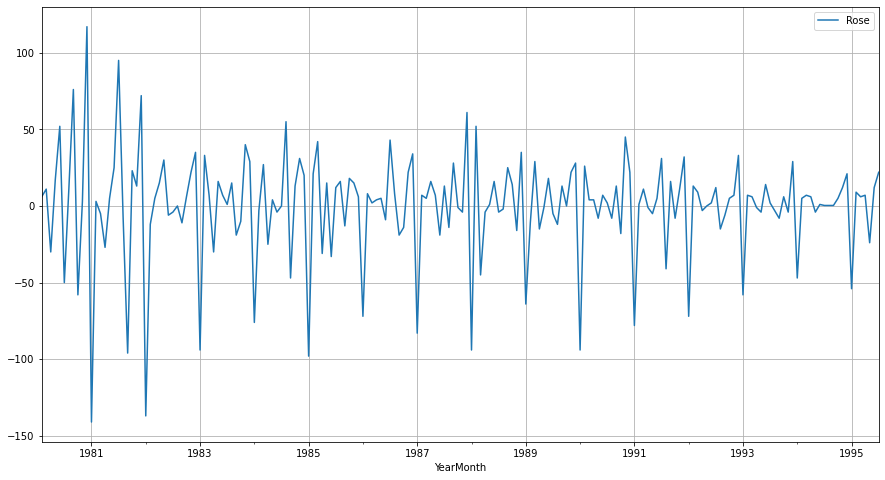

In [90]:
df3.diff().dropna().plot(grid=True);

In [91]:
new_df1 = df3.diff().dropna()

In [92]:
new_dftest1 = adfuller(new_df1,regression='ct')
print('DF test statistic is %3.3f' %new_dftest1[0])
print('DF test p-value is' ,new_dftest1[1])
print('Number of lags used' ,new_dftest1[2])

DF test statistic is -8.162
DF test p-value is 3.015976115828316e-11
Number of lags used 12


In [93]:
# Plot the Autocorrelation and the Partial Autocorrelation function plots on the whole data after 1st order Differencing

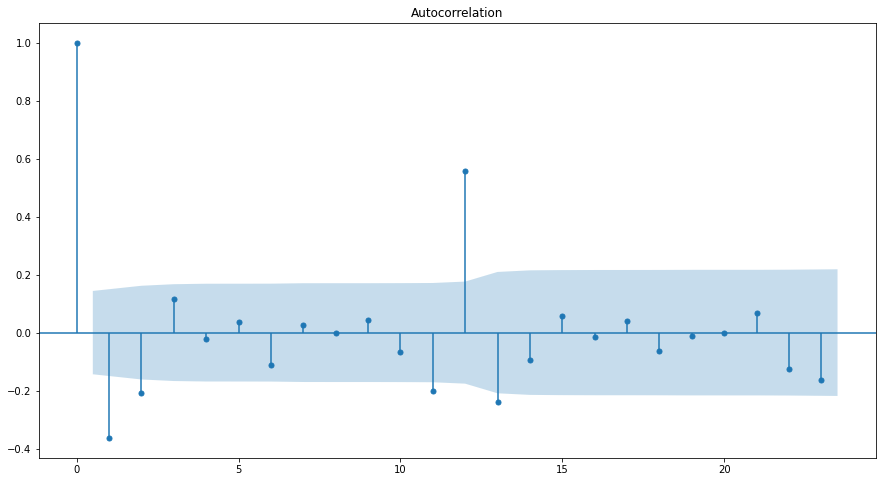

In [100]:
plot_acf(new_df1,alpha=0.05);

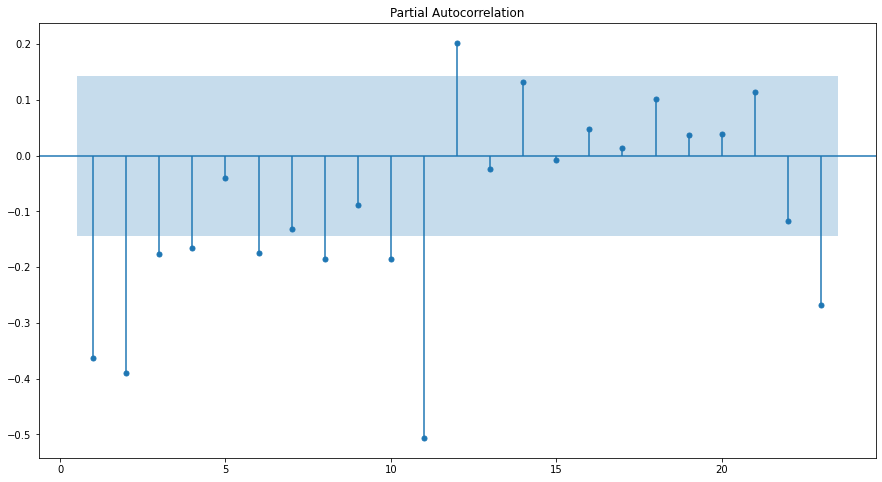

In [99]:
plot_pacf(new_df1,zero=False,alpha=0.05,method='ywmle');

In [102]:
p = range(2, 6)
q = range(1,4)
d= range(1,2)
D = range(0,1)
pdq = list(itertools.product(p, d, q))
PDQ = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, D, q))]
print('Examples of the parameter combinations for the Model are')
for i in range(1,len(pdq)):
    print('Model: {}{}'.format(pdq[i], PDQ[i]))

Examples of the parameter combinations for the Model are
Model: (2, 1, 2)(2, 0, 2, 12)
Model: (2, 1, 3)(2, 0, 3, 12)
Model: (3, 1, 1)(3, 0, 1, 12)
Model: (3, 1, 2)(3, 0, 2, 12)
Model: (3, 1, 3)(3, 0, 3, 12)
Model: (4, 1, 1)(4, 0, 1, 12)
Model: (4, 1, 2)(4, 0, 2, 12)
Model: (4, 1, 3)(4, 0, 3, 12)
Model: (5, 1, 1)(5, 0, 1, 12)
Model: (5, 1, 2)(5, 0, 2, 12)
Model: (5, 1, 3)(5, 0, 3, 12)


In [103]:
SARIMA_AIC1 = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC1

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []

In [105]:
for param in pdq:
    for param_seasonal in PDQ:
        SARIMA_model = sm.tsa.statespace.SARIMAX(df3_Train['Rose'].values,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA = SARIMA_model.fit(maxiter=1000)
        print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
        SARIMA_AIC1 = SARIMA_AIC1.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)

SARIMA(2, 1, 1)x(2, 0, 1, 12) - AIC:897.639956536955
SARIMA(2, 1, 1)x(2, 0, 2, 12) - AIC:899.4835866288954


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 1)x(2, 0, 3, 12) - AIC:3724.447555964424
SARIMA(2, 1, 1)x(3, 0, 1, 12) - AIC:787.3639259064494
SARIMA(2, 1, 1)x(3, 0, 2, 12) - AIC:787.0598888442282
SARIMA(2, 1, 1)x(3, 0, 3, 12) - AIC:3593.5160318249104
SARIMA(2, 1, 1)x(4, 0, 1, 12) - AIC:690.0221237325583
SARIMA(2, 1, 1)x(4, 0, 2, 12) - AIC:690.3782228744116


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 1)x(4, 0, 3, 12) - AIC:2939.8452507296834
SARIMA(2, 1, 1)x(5, 0, 1, 12) - AIC:588.5235164770137
SARIMA(2, 1, 1)x(5, 0, 2, 12) - AIC:590.3140463003859


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 1)x(5, 0, 3, 12) - AIC:3298.1924253822585
SARIMA(2, 1, 2)x(2, 0, 1, 12) - AIC:898.3781889114674
SARIMA(2, 1, 2)x(2, 0, 2, 12) - AIC:890.6687980804124


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)x(2, 0, 3, 12) - AIC:2962.5650919623554
SARIMA(2, 1, 2)x(3, 0, 1, 12) - AIC:786.9410035240284
SARIMA(2, 1, 2)x(3, 0, 2, 12) - AIC:786.9640515738926


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)x(3, 0, 3, 12) - AIC:3322.334445378469
SARIMA(2, 1, 2)x(4, 0, 1, 12) - AIC:691.6930190288767
SARIMA(2, 1, 2)x(4, 0, 2, 12) - AIC:692.3428736166296


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)x(4, 0, 3, 12) - AIC:3040.982455293013
SARIMA(2, 1, 2)x(5, 0, 1, 12) - AIC:589.3298191797492
SARIMA(2, 1, 2)x(5, 0, 2, 12) - AIC:591.2610752545401


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)x(5, 0, 3, 12) - AIC:2461.4437257612103
SARIMA(2, 1, 3)x(2, 0, 1, 12) - AIC:903.2328123179304
SARIMA(2, 1, 3)x(2, 0, 2, 12) - AIC:879.2191809674049


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 3)x(2, 0, 3, 12) - AIC:3687.168658560664
SARIMA(2, 1, 3)x(3, 0, 1, 12) - AIC:783.4101471700199
SARIMA(2, 1, 3)x(3, 0, 2, 12) - AIC:781.0452515796673


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 3)x(3, 0, 3, 12) - AIC:3669.790950869278
SARIMA(2, 1, 3)x(4, 0, 1, 12) - AIC:689.4996580202701
SARIMA(2, 1, 3)x(4, 0, 2, 12) - AIC:690.3364319845632


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 3)x(4, 0, 3, 12) - AIC:2949.0507638380386
SARIMA(2, 1, 3)x(5, 0, 1, 12) - AIC:591.0477261503136
SARIMA(2, 1, 3)x(5, 0, 2, 12) - AIC:592.9478206925648
SARIMA(2, 1, 3)x(5, 0, 3, 12) - AIC:2761.758559499567
SARIMA(3, 1, 1)x(2, 0, 1, 12) - AIC:888.327920853833
SARIMA(3, 1, 1)x(2, 0, 2, 12) - AIC:890.1571522953449


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1)x(2, 0, 3, 12) - AIC:3398.268902540144
SARIMA(3, 1, 1)x(3, 0, 1, 12) - AIC:775.4953300778068
SARIMA(3, 1, 1)x(3, 0, 2, 12) - AIC:774.4002874005364


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1)x(3, 0, 3, 12) - AIC:3890.2516499532367
SARIMA(3, 1, 1)x(4, 0, 1, 12) - AIC:683.7410087003673
SARIMA(3, 1, 1)x(4, 0, 2, 12) - AIC:685.0110947184768


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1)x(4, 0, 3, 12) - AIC:3244.0140302894124
SARIMA(3, 1, 1)x(5, 0, 1, 12) - AIC:584.188393656422
SARIMA(3, 1, 1)x(5, 0, 2, 12) - AIC:585.9808083273101


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 1)x(5, 0, 3, 12) - AIC:3172.8679394012024
SARIMA(3, 1, 2)x(2, 0, 1, 12) - AIC:890.3277441364618
SARIMA(3, 1, 2)x(2, 0, 2, 12) - AIC:896.1431520466706


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 2)x(2, 0, 3, 12) - AIC:3891.2539078149202
SARIMA(3, 1, 2)x(3, 0, 1, 12) - AIC:776.3462137736811
SARIMA(3, 1, 2)x(3, 0, 2, 12) - AIC:774.88093634827
SARIMA(3, 1, 2)x(3, 0, 3, 12) - AIC:3753.0746082654564
SARIMA(3, 1, 2)x(4, 0, 1, 12) - AIC:685.7388599780256
SARIMA(3, 1, 2)x(4, 0, 2, 12) - AIC:686.6692133526185


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 2)x(4, 0, 3, 12) - AIC:3037.540815050591
SARIMA(3, 1, 2)x(5, 0, 1, 12) - AIC:576.6362518407656
SARIMA(3, 1, 2)x(5, 0, 2, 12) - AIC:578.6268554951422


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 2)x(5, 0, 3, 12) - AIC:2103.6283367772353
SARIMA(3, 1, 3)x(2, 0, 1, 12) - AIC:885.9217100767557
SARIMA(3, 1, 3)x(2, 0, 2, 12) - AIC:880.5595714950235
SARIMA(3, 1, 3)x(2, 0, 3, 12) - AIC:3395.8552976387577
SARIMA(3, 1, 3)x(3, 0, 1, 12) - AIC:776.3690408935078
SARIMA(3, 1, 3)x(3, 0, 2, 12) - AIC:778.2316183115659


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 3)x(3, 0, 3, 12) - AIC:3396.8491526969
SARIMA(3, 1, 3)x(4, 0, 1, 12) - AIC:685.0969304830521
SARIMA(3, 1, 3)x(4, 0, 2, 12) - AIC:684.6844271254761
SARIMA(3, 1, 3)x(4, 0, 3, 12) - AIC:3259.1418178106933
SARIMA(3, 1, 3)x(5, 0, 1, 12) - AIC:583.7463447591562
SARIMA(3, 1, 3)x(5, 0, 2, 12) - AIC:585.7449126165508


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 1, 3)x(5, 0, 3, 12) - AIC:2884.239532188375
SARIMA(4, 1, 1)x(2, 0, 1, 12) - AIC:881.9652791503048
SARIMA(4, 1, 1)x(2, 0, 2, 12) - AIC:883.8672137402455


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 1)x(2, 0, 3, 12) - AIC:3132.4726011960984
SARIMA(4, 1, 1)x(3, 0, 1, 12) - AIC:766.6969173778909
SARIMA(4, 1, 1)x(3, 0, 2, 12) - AIC:765.7476012631922


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 1)x(3, 0, 3, 12) - AIC:3065.0772446266374
SARIMA(4, 1, 1)x(4, 0, 1, 12) - AIC:676.8230706375987
SARIMA(4, 1, 1)x(4, 0, 2, 12) - AIC:677.9137527238164


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 1)x(4, 0, 3, 12) - AIC:2665.2640074010014
SARIMA(4, 1, 1)x(5, 0, 1, 12) - AIC:571.8851071658927
SARIMA(4, 1, 1)x(5, 0, 2, 12) - AIC:573.7502724570427


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 1)x(5, 0, 3, 12) - AIC:2261.3113708838537
SARIMA(4, 1, 2)x(2, 0, 1, 12) - AIC:881.8622733776989
SARIMA(4, 1, 2)x(2, 0, 2, 12) - AIC:883.6752357314448
SARIMA(4, 1, 2)x(2, 0, 3, 12) - AIC:2031.5425663005524
SARIMA(4, 1, 2)x(3, 0, 1, 12) - AIC:767.1654132073871
SARIMA(4, 1, 2)x(3, 0, 2, 12) - AIC:766.1613977992739


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 2)x(3, 0, 3, 12) - AIC:1818.554839895022
SARIMA(4, 1, 2)x(4, 0, 1, 12) - AIC:677.6413974755685
SARIMA(4, 1, 2)x(4, 0, 2, 12) - AIC:685.9829756086167


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 2)x(4, 0, 3, 12) - AIC:900.3156752836348
SARIMA(4, 1, 2)x(5, 0, 1, 12) - AIC:568.7558637977739
SARIMA(4, 1, 2)x(5, 0, 2, 12) - AIC:570.7489323093888
SARIMA(4, 1, 2)x(5, 0, 3, 12) - AIC:100.90316559278499
SARIMA(4, 1, 3)x(2, 0, 1, 12) - AIC:880.9595122488669
SARIMA(4, 1, 3)x(2, 0, 2, 12) - AIC:882.1409670112388


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 3)x(2, 0, 3, 12) - AIC:3616.047992397304
SARIMA(4, 1, 3)x(3, 0, 1, 12) - AIC:775.0755074578638
SARIMA(4, 1, 3)x(3, 0, 2, 12) - AIC:772.9863219420943


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 3)x(3, 0, 3, 12) - AIC:3617.3716589787937
SARIMA(4, 1, 3)x(4, 0, 1, 12) - AIC:677.6281366773579
SARIMA(4, 1, 3)x(4, 0, 2, 12) - AIC:679.6142572961119


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 3)x(4, 0, 3, 12) - AIC:3081.5343256254364
SARIMA(4, 1, 3)x(5, 0, 1, 12) - AIC:570.4286443562152
SARIMA(4, 1, 3)x(5, 0, 2, 12) - AIC:570.261336191873


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 3)x(5, 0, 3, 12) - AIC:1801.8488615745614
SARIMA(5, 1, 1)x(2, 0, 1, 12) - AIC:874.9373960171064
SARIMA(5, 1, 1)x(2, 0, 2, 12) - AIC:876.75516858097


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(5, 1, 1)x(2, 0, 3, 12) - AIC:3074.5125559042744
SARIMA(5, 1, 1)x(3, 0, 1, 12) - AIC:761.0551145329514
SARIMA(5, 1, 1)x(3, 0, 2, 12) - AIC:760.2289434724245


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(5, 1, 1)x(3, 0, 3, 12) - AIC:2457.3127970376645
SARIMA(5, 1, 1)x(4, 0, 1, 12) - AIC:670.4085949913956
SARIMA(5, 1, 1)x(4, 0, 2, 12) - AIC:672.2388986873283


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(5, 1, 1)x(4, 0, 3, 12) - AIC:2868.5943762871116
SARIMA(5, 1, 1)x(5, 0, 1, 12) - AIC:560.4584060601162
SARIMA(5, 1, 1)x(5, 0, 2, 12) - AIC:562.071708339031


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(5, 1, 1)x(5, 0, 3, 12) - AIC:2491.0603222946024
SARIMA(5, 1, 2)x(2, 0, 1, 12) - AIC:892.8865724324952
SARIMA(5, 1, 2)x(2, 0, 2, 12) - AIC:878.6609772345955
SARIMA(5, 1, 2)x(2, 0, 3, 12) - AIC:3745.0672910067683
SARIMA(5, 1, 2)x(3, 0, 1, 12) - AIC:761.3087692109492
SARIMA(5, 1, 2)x(3, 0, 2, 12) - AIC:760.3366306154207


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(5, 1, 2)x(3, 0, 3, 12) - AIC:3230.4907450591754
SARIMA(5, 1, 2)x(4, 0, 1, 12) - AIC:685.2161736576539
SARIMA(5, 1, 2)x(4, 0, 2, 12) - AIC:671.7189497840704


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(5, 1, 2)x(4, 0, 3, 12) - AIC:2935.9166511378057
SARIMA(5, 1, 2)x(5, 0, 1, 12) - AIC:573.8551252530477
SARIMA(5, 1, 2)x(5, 0, 2, 12) - AIC:577.0552889899784


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(5, 1, 2)x(5, 0, 3, 12) - AIC:2749.4209559191345
SARIMA(5, 1, 3)x(2, 0, 1, 12) - AIC:878.7902290857985
SARIMA(5, 1, 3)x(2, 0, 2, 12) - AIC:875.954504813493
SARIMA(5, 1, 3)x(2, 0, 3, 12) - AIC:4821.753635759257
SARIMA(5, 1, 3)x(3, 0, 1, 12) - AIC:765.9040894677469
SARIMA(5, 1, 3)x(3, 0, 2, 12) - AIC:761.8213999500745
SARIMA(5, 1, 3)x(3, 0, 3, 12) - AIC:4393.875428352832
SARIMA(5, 1, 3)x(4, 0, 1, 12) - AIC:672.0475038990576
SARIMA(5, 1, 3)x(4, 0, 2, 12) - AIC:672.1268331063723


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(5, 1, 3)x(4, 0, 3, 12) - AIC:3606.904134901304
SARIMA(5, 1, 3)x(5, 0, 1, 12) - AIC:568.4647434382065
SARIMA(5, 1, 3)x(5, 0, 2, 12) - AIC:560.0414892750442


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(5, 1, 3)x(5, 0, 3, 12) - AIC:2677.8153315141617


In [106]:
SARIMA_AIC1.sort_values(by=['AIC']).head()

param       seasonal         AIC
95   (4, 1, 2)  (5, 0, 3, 12)  100.903166
142  (5, 1, 3)  (5, 0, 2, 12)  560.041489
117  (5, 1, 1)  (5, 0, 1, 12)  560.458406
118  (5, 1, 1)  (5, 0, 2, 12)  562.071708
141  (5, 1, 3)  (5, 0, 1, 12)  568.464743

In [112]:
auto_SARIMA1 = sm.tsa.statespace.SARIMAX(df3_Train['Rose'],
                                order=(5, 1, 3),
                                seasonal_order=(5, 0, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_auto_SARIMA1 = auto_SARIMA1.fit(maxiter=1000)
print(results_auto_SARIMA1.summary())

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                        SARIMAX Results                                        
Dep. Variable:                                    Rose   No. Observations:                  132
Model:             SARIMAX(5, 1, 3)x(5, 0, [1, 2], 12)   Log Likelihood                -264.021
Date:                                 Thu, 16 Dec 2021   AIC                            560.041
Time:                                         13:53:05   BIC                            595.076
Sample:                                     01-01-1980   HQIC                           573.885
                                          - 12-01-1990                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4592      0.219      2.094      0.036       0.029       0

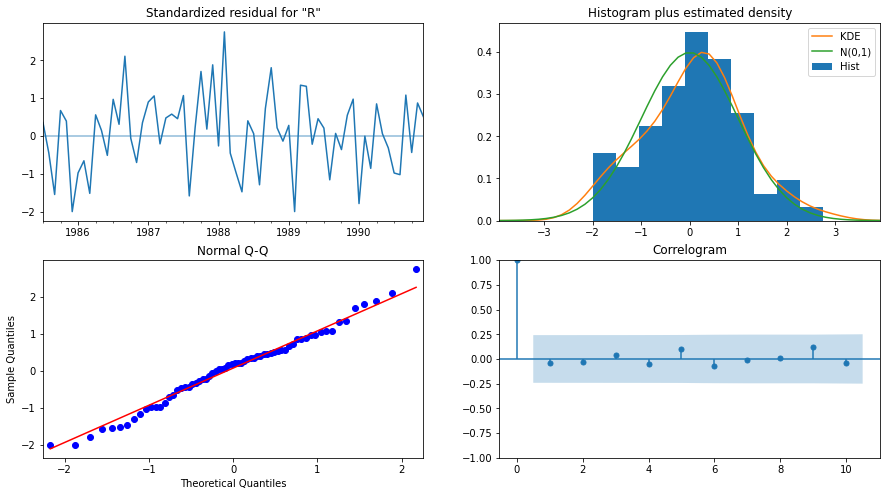

In [113]:
results_auto_SARIMA1.plot_diagnostics();

In [114]:
predicted_auto_SARIMA1 = results_auto_SARIMA1.get_forecast(steps=len(df3_Test))

In [115]:
rmse_model7_1 = mean_squared_error(df3_Test['Rose'],predicted_auto_SARIMA1.predicted_mean,squared=False)

print("For Auto SARIMA Model forecast on the Training Data,  RMSE is %3.3f " %(rmse_model7_1))

For Auto SARIMA Model forecast on the Training Data,  RMSE is 18.609 


In [121]:
resultsDf_7_1 = pd.DataFrame({'Test RMSE': [rmse_model7_1]}
                           ,index=['AutoSARIMA(5, 1, 3)(5, 0, 2, 12)'])

resultsDf1 = pd.concat([resultsDf1, resultsDf_7_1])


In [117]:
manual_SARIMA1 = sm.tsa.statespace.SARIMAX(df3_Train['Rose'],
                                order=(5, 1, 3),
                                seasonal_order=(4, 0, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_manual_SARIMA1 = manual_SARIMA1.fit(maxiter=1000)
print(results_manual_SARIMA1.summary())

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                        SARIMAX Results                                        
Dep. Variable:                                    Rose   No. Observations:                  132
Model:             SARIMAX(5, 1, 3)x(4, 0, [1, 2], 12)   Log Likelihood                -321.063
Date:                                 Thu, 16 Dec 2021   AIC                            672.127
Time:                                         14:02:41   BIC                            707.477
Sample:                                     01-01-1980   HQIC                           686.278
                                          - 12-01-1990                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0920      0.162     -6.742      0.000      -1.409      -0

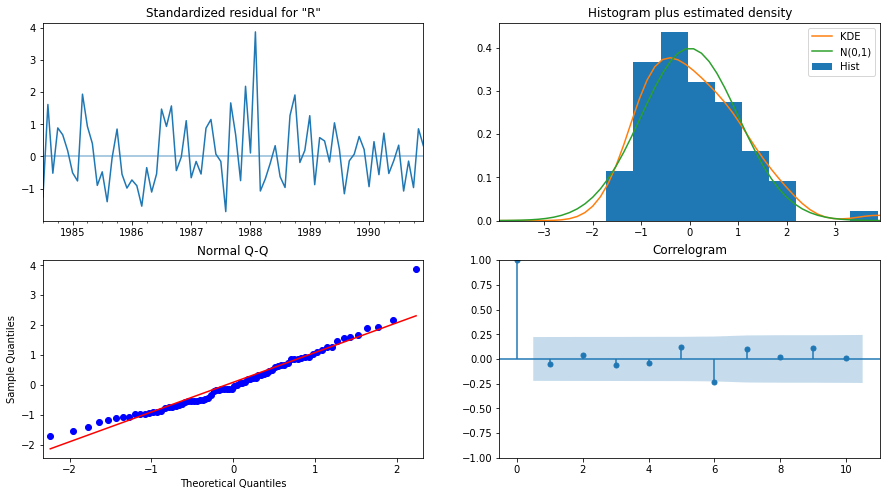

In [118]:
results_manual_SARIMA1.plot_diagnostics();

In [119]:
predicted_manual_SARIMA1 = results_manual_SARIMA1.get_forecast(steps=len(df3_Test))

In [120]:
rmse_model8_1 = mean_squared_error(df3_Test['Rose'],predicted_manual_SARIMA1.predicted_mean,squared=False)

print("For Manual SARIMA Model forecast on the Training Data,  RMSE is %3.3f " %(rmse_model8_1))

For Manual SARIMA Model forecast on the Training Data,  RMSE is 19.015 


In [122]:
resultsDf_8_1 = pd.DataFrame({'Test RMSE': [rmse_model8_1]}
                           ,index=['AutoSARIMA(5, 1, 3)(4, 0, 2, 12)'])

resultsDf1 = pd.concat([resultsDf1, resultsDf_8_1])


In [123]:
resultsDf1

Test RMSE
Alpha=0.098,SES                              36.796241
Alpha=1.49,Beta=1.66:DES                     15.268944
Alpha=0.088,Beta=9.006e-06,Gamma=0.0003:TES  14.255619
Alpha=0.076,Beta=0.041,Gamma=0.0008:TESm     19.397143
Linear Regression                            15.433446
NaiveModel                                   79.718773
SimpleAverageModel                           53.460570
2pointTrailingMovingAverage                  11.529278
4pointTrailingMovingAverage                  14.451403
6pointTrailingMovingAverage                  14.566327
AutoSARIMA(5, 1, 3)(5, 0, 2, 12)             18.608984
AutoSARIMA(5, 1, 3)(4, 0, 2, 12)             19.014706

In [ ]:
# Forcasting for Next 12 Months

In [168]:
fullmodel2=ExponentialSmoothing(df3,
                                  trend='additive',
                                  seasonal='additive').fit(smoothing_level=0.08872764725999983,
                                                                 smoothing_trend=9.006425383910208e-06,
                                                                 smoothing_seasonal=0.00030220468692033)

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [169]:
RMSE_fullmodel2 = metrics.mean_squared_error(df3['Rose'],fullmodel2.fittedvalues,squared=False)

In [170]:
print('RMSE:',RMSE_fullmodel2)

RMSE: 17.664104202163752


In [171]:
Future_forecast2 = fullmodel2.forecast(steps=12)

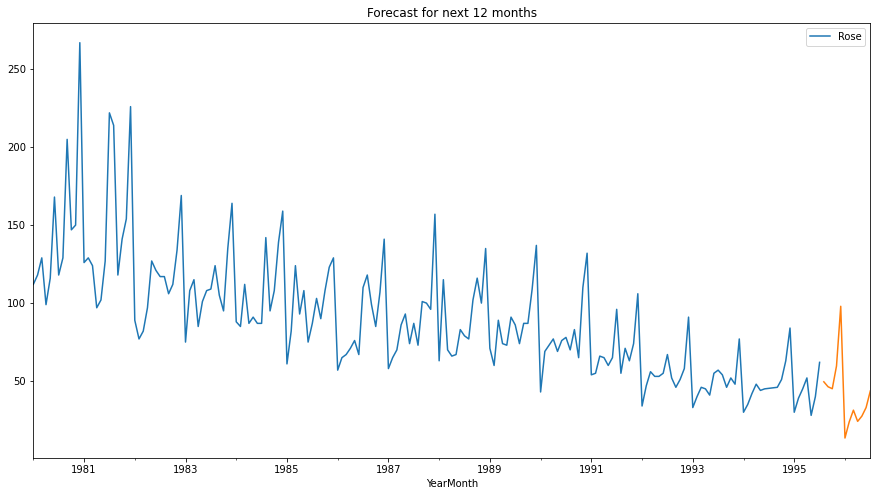

In [172]:
df3.plot()
Future_forecast2.plot()
plt.title('Forecast for next 12 months');